In [19]:
from glob import glob
import sys
import getpass
import os
# import psutil
from os.path import join, exists
from os.path import getsize
import pickle as pkl
import numpy as np
import pandas as pd
import scipy
from scipy.stats import rankdata
import statannot

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import seaborn as sns
import statsmodels.stats.multitest
# from statsmodels.sandbox.stats.multicomp import multipletests

# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiSpheresMasker
# from nilearn.regions import connected_label_regions
from nilearn.connectome import ConnectivityMeasure
import nilearn.decoding

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

In [2]:
## experimental properties
list_subj = np.array(
    ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15'
     ,'18', '19', '20', '21', '23', '26', '27', '28', '29', '30'
     ,'31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
)
list_stage = np.array(
    ['early_practice', 'early_unpractice', 'late_practice', 'late_unpractice']
)
list_run = np.array(
    ['r%02d'%(r+1) for r in range(6)]
)

In [3]:
dir_fmri = '/mnt/sda2/GA/fmri_data/'
dir_root = '/home/sungbeenpark/GA'

---

In [4]:
def calc_recruitment(A, S):
    """
    INPUT
        A: numpy.ndarray
            N x N Adjacency Matrix
        S: numpy.array
            N x 1 static community made up of k networks.
    OUTPUT
        recuitment: numpy.array
            N x 1 recuitment
    """
    (N, n) = A.shape
    assert N==n
    (k,) = S.shape
    assert N==k
    
    recruitment = np.ones(N) * np.nan
    for node, network in enumerate(S):
        recruitment[node] = np.nanmean(A[node, S==network])
    
    return recruitment

In [5]:
def calc_integration(A, S):
    """
    INPUT
        A: numpy.ndarray
            N x N Adjacency Matrix
        S: numpy.array
            N x 1 static community made up of k networks.
    OUTPUT
        integration: numpy.array
            N x 1 integration
    """
    (N, n) = A.shape
    assert N==n
    (k,) = S.shape
    assert N==k
    
    integration = np.ones(N) * np.nan
    for node, network in enumerate(S):
        integration[node] = np.nanmean(A[node, S!=network])
    
    return integration

In [6]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

---

## Mohr 264 atlas
NiftiSpheresMasker: 3dmaskave 와 결과 거의 비슷한 걸 확인함.

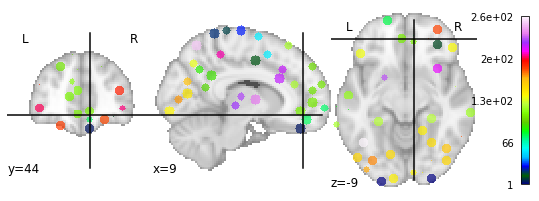

In [38]:
# list_path = sorted(glob("/mnt/sda2/Mohr264/Mohr???.nii"))

# for ii, path in enumerate(list_path):
#     if ii>0:
#         atlas = niimg.math_img(img1=atlas, img2=path, formula="img1 + %d*img2"%(ii+1))
#     else:
#         atlas = niimg.load_img(path)

# nplt.plot_roi(atlas, colorbar=True)

In [7]:
df_Mohr = pd.read_csv(
    '/mnt/sda2/Mohr264/Mohr264.csv'
    , header=0, index_col=None, sep='\t'
)
df_Mohr

Node-No.  MNI x  MNI y  MNI z               Network-No.
0           1    -24    -99    -12              Not assigned
1           2     27    -96    -12              Not assigned
2           3     24     33    -18              Not assigned
3           4    -57    -45    -24              Not assigned
4           5      9     42    -24              Not assigned
..        ...    ...    ...    ...                       ...
259       260    -27    -72     36  Dorsal Attention Network
260       261    -33      0     54  Dorsal Attention Network
261       262    -42    -60     -9  Dorsal Attention Network
262       263    -18    -60     63  Dorsal Attention Network
263       264     30     -6     54  Dorsal Attention Network

[264 rows x 5 columns]

---

## 1. Load the time-series

In [8]:
# stat = 'pb04.errts_tproject'
stat = 'GLM.RO'
fname = "time_series.%s.Mohr264.pkl"%stat

with open(join(dir_root, 'tsmean/Mohr264', fname), 'rb') as f:
    time_series = pickle.load(f)
    
print(list(time_series.keys())[:10])
print(time_series[('GA01', 'r01')].shape)

[('GA01', 'r01'), ('GA01', 'r02'), ('GA01', 'r03'), ('GA01', 'r04'), ('GA01', 'r05'), ('GA01', 'r06'), ('GB01', 'r01'), ('GB01', 'r02'), ('GB01', 'r03'), ('GB01', 'r04')]
(1096, 264)


In [9]:
df = df_Mohr.sort_values(by=['Network-No.'])
# networks = df_Mohr['Network-No.'].values
df

Node-No.  MNI x  MNI y  MNI z       Network-No.
69         70    -54     -9     12  Auditory Network
60         61     33    -27     12  Auditory Network
61         62     66    -33     21  Auditory Network
62         63     57    -15      6  Auditory Network
63         64    -39    -33     18  Auditory Network
..        ...    ...    ...    ...               ...
171       172    -33    -78    -12     Visual Cortex
170       171    -27    -90      3     Visual Cortex
169       170      6    -81      6     Visual Cortex
162       163      6    -72     24     Visual Cortex
157       158     21    -87     -3     Visual Cortex

[264 rows x 5 columns]

## 2. Correlation matrix is used as a weighted edge in the network

In [10]:
# BOLDshape = (1095, 103) # 1095 = 3*5*73
# BOLDshape = (1096, 103) # 1096 = 2^3*137
BOLDshape = time_series[('GA01', 'r01')].shape

## The number of windows per Run
wpr = 8

## The width of the window
WW = BOLDshape[0]//wpr

## The number of nodes
nnodes = BOLDshape[-1]
# nnodes = tsmean['labels']

OUTPUTshape = (wpr,WW,nnodes)
print(OUTPUTshape)

(8, 137, 264)


In [11]:
measure = ConnectivityMeasure(kind='correlation')

## (2 dates, 30 subjects, 6 runs, 8 windows, 264 nodes, 264 nodes)
Tcorr = np.ones((2,30,6,8,264,264))
for (subj, run), ts in time_series.items():
    gg, nn = subj[:2], subj[2:]
    idx_rr = np.where(list_run==run)[0][0]
    idx_nn = np.where(list_subj==nn)[0][0]
    idx_gg = 0 if gg=='GA' else (1 if gg=='GB' else 'invalid')
    
    ## (8 windows, 137 time points, 264 nodes)
    windowed_time_series = ts.reshape(OUTPUTshape)
        
    Tcorr[idx_gg, idx_nn, idx_rr] = measure.fit_transform(windowed_time_series)
Tcorr.shape

(2, 30, 6, 8, 264, 264)

In [12]:
tmp = np.nanmean(Tcorr, axis=3)
tmp = np.nanmean(tmp, axis=1)
print(tmp.shape)
corr_ep = np.nanmean(tmp[0,:3], axis=0)
corr_eu = np.nanmean(tmp[0,3:], axis=0)
corr_lp = np.nanmean(tmp[1,:3], axis=0)
corr_lu = np.nanmean(tmp[1,3:], axis=0)

(2, 6, 264, 264)


In [13]:
def sorted_corrmat(df, corr):
    tmp = df.sort_values(by=['Network-No.'])
    sorted_labels = tmp['Network-No.'].values
    
    sorted_corr = np.ones((len(sorted_labels), len(sorted_labels))) * np.nan
    new_row = 0
    for row, network in tmp['Network-No.'].items():
        new_col = 0
        for col, network in tmp['Network-No.'].items():
            sorted_corr[new_row][new_col] = corr[row][col]
            new_col += 1
        new_row += 1
        
    return sorted_corr, sorted_labels

GLM.RO


/tmp/ipykernel_8928/560305387.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


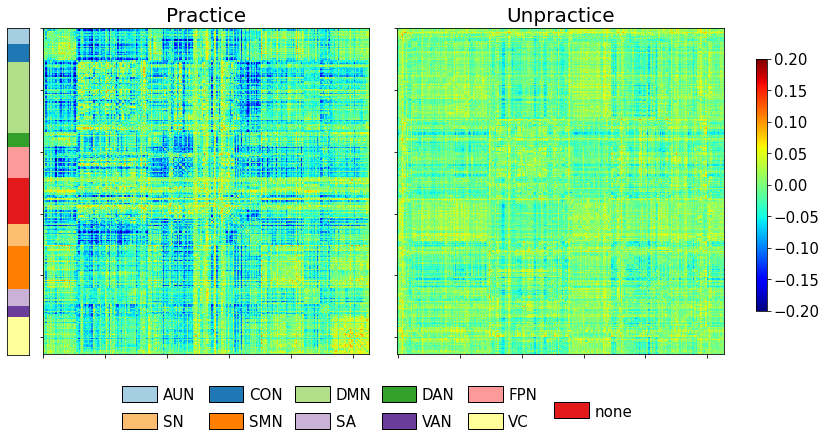

In [14]:
print(stat)

nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
# axs = np.concatenate(axs)

## practice
corr = corr_lp-corr_ep
sorted_corr, sorted_labels = sorted_corrmat(df=df_Mohr, corr=corr)

ax=axs[0]
img = nplt.plot_matrix(
    mat=sorted_corr
    , tri='full'
    , cmap='jet', vmax=.2, vmin=-.2, colorbar=False
    , axes=ax
#     , title='practice'
)
ax.set_title('Practice', fontsize=20)

## unpractice
corr = corr_lu-corr_eu
sorted_corr, sorted_labels = sorted_corrmat(df=df_Mohr, corr=corr)

ax=axs[1]
img = nplt.plot_matrix(
    mat=corr
    , tri='full'
    , cmap='jet', vmax=.2, vmin=-.2, colorbar=False
    , axes=ax
#     , title='unpractice'
)
ax.set_title('Unpractice', fontsize=20)

## network label
lax = fig.add_axes([-.02, 0.027, 0.03, .908])
lax.set_xticklabels([])
lax.set_yticklabels([])
lax.tick_params(left=False, bottom=False)

cmap = plt.get_cmap('Paired')
tot = len(sorted_labels)
comulative_ratio = 0
for ii, network in enumerate(np.unique(sorted_labels)):
    ratio = (sorted_labels==network).sum() / tot
    lax.add_patch(Rectangle((0,1-comulative_ratio),1,-ratio, facecolor=cmap(ii), fill=True))
    comulative_ratio += ratio
    
## color bar
cax = fig.add_axes([1.02, .15, .015, .7])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=15)

## networks
tmp = ['AUN', 'CON', 'DMN', 'DAN', 'FPN', 'none', 'SN', 'SMN', 'SA', 'VAN', 'VC']
nax = fig.add_axes([0.1, -.2, .8, .15])
# nax.add_patch(Rectangle((0.05,.75),.06,.15, facecolor=cmap(0), edgecolor='k'))
# nax.text(.12, .81, "AUN", fontsize=15, horizontalalignment='left', verticalalignment='center')
# nax.add_patch(Rectangle((0.2,.75),.06,.15, facecolor=cmap(1), edgecolor='k'))
# nax.text(.27, .81, "CON", fontsize=15, horizontalalignment='left', verticalalignment='center')
for ii, name in enumerate(tmp):
    if ii<5:
        x = 0.05+0.15*ii
        y = .65
    elif name=='none':
        x = 0.8
        y = .35
    else:
        x = 0.05+0.15*(ii-6)
        y = .15
    nax.add_patch(Rectangle((x,y),.06,.3, facecolor=cmap(ii), edgecolor='k'))
    nax.text(x+.07, y+.12, name, fontsize=15, horizontalalignment='left', verticalalignment='center')        
    
nax.axis('off')

fig.tight_layout()

GLM.MO


/tmp/ipykernel_186277/560305387.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


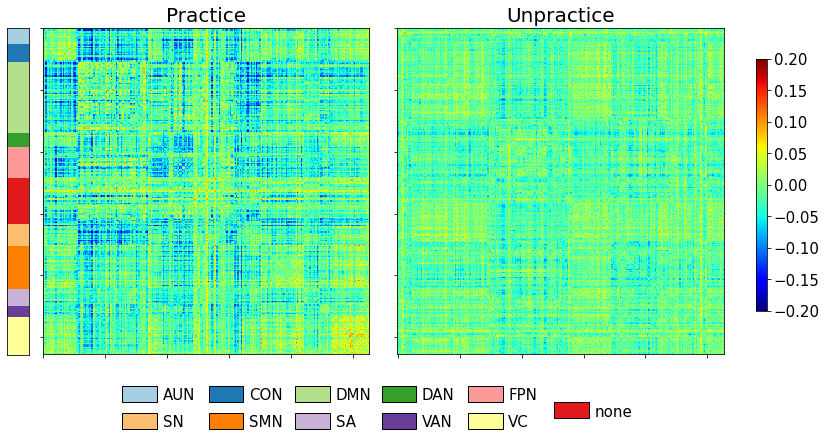

In [63]:
print(stat)

nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
# axs = np.concatenate(axs)

## practice
corr = corr_lp-corr_ep
sorted_corr, sorted_labels = sorted_corrmat(df=df_Mohr, corr=corr)

ax=axs[0]
img = nplt.plot_matrix(
    mat=sorted_corr
    , tri='full'
    , cmap='jet', vmax=.2, vmin=-.2, colorbar=False
    , axes=ax
#     , title='practice'
)
ax.set_title('Practice', fontsize=20)

## unpractice
corr = corr_lu-corr_eu
sorted_corr, sorted_labels = sorted_corrmat(df=df_Mohr, corr=corr)

ax=axs[1]
img = nplt.plot_matrix(
    mat=corr
    , tri='full'
    , cmap='jet', vmax=.2, vmin=-.2, colorbar=False
    , axes=ax
#     , title='unpractice'
)
ax.set_title('Unpractice', fontsize=20)

## network label
lax = fig.add_axes([-.02, 0.027, 0.03, .908])
lax.set_xticklabels([])
lax.set_yticklabels([])
lax.tick_params(left=False, bottom=False)

cmap = plt.get_cmap('Paired')
tot = len(sorted_labels)
comulative_ratio = 0
for ii, network in enumerate(np.unique(sorted_labels)):
    ratio = (sorted_labels==network).sum() / tot
    lax.add_patch(Rectangle((0,1-comulative_ratio),1,-ratio, facecolor=cmap(ii), fill=True))
    comulative_ratio += ratio
    
## color bar
cax = fig.add_axes([1.02, .15, .015, .7])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=15)

## networks
tmp = ['AUN', 'CON', 'DMN', 'DAN', 'FPN', 'none', 'SN', 'SMN', 'SA', 'VAN', 'VC']
nax = fig.add_axes([0.1, -.2, .8, .15])
# nax.add_patch(Rectangle((0.05,.75),.06,.15, facecolor=cmap(0), edgecolor='k'))
# nax.text(.12, .81, "AUN", fontsize=15, horizontalalignment='left', verticalalignment='center')
# nax.add_patch(Rectangle((0.2,.75),.06,.15, facecolor=cmap(1), edgecolor='k'))
# nax.text(.27, .81, "CON", fontsize=15, horizontalalignment='left', verticalalignment='center')
for ii, name in enumerate(tmp):
    if ii<5:
        x = 0.05+0.15*ii
        y = .65
    elif name=='none':
        x = 0.8
        y = .35
    else:
        x = 0.05+0.15*(ii-6)
        y = .15
    nax.add_patch(Rectangle((x,y),.06,.3, facecolor=cmap(ii), edgecolor='k'))
    nax.text(x+.07, y+.12, name, fontsize=15, horizontalalignment='left', verticalalignment='center')        
    
nax.axis('off')

fig.tight_layout()

In [15]:
fig.savefig(
    '/home/sungbeenpark/GA/network.corrmat.%s.Mohr264.png'%stat, dpi=300
    , bbox_inches = "tight"
)

In [44]:
global_activity = np.random.rand(10)
global_activity

array([2.87481019e-01, 2.37132553e-01, 9.20414103e-01, 1.49632931e-01,
       4.74517458e-01, 6.12176147e-04, 9.81377134e-01, 7.47169935e-01,
       4.44879646e-01, 7.50731860e-02])

In [45]:
z = global_activity / np.linalg.norm(global_activity)
z

array([1.67136896e-01, 1.37865098e-01, 5.35114134e-01, 8.69942086e-02,
       2.75876910e-01, 3.55909484e-04, 5.70557071e-01, 4.34392727e-01,
       2.58645957e-01, 4.36463574e-02])

In [46]:
M = np.outer(z, z)
M.shape

(10, 10)

In [ ]:
## ort_global
### normalize a vector of global activity
z = global_activity / np.linalg.norm(global_activity)
M = np.outer(z, z)

## partial correlation
a = a - np.matmul(M, a)
b = b - np.matmul(M, b)

## 2-2 Measurements

In [16]:
## data
print(Tcorr.shape)
full_networks = df_Mohr['Network-No.'].values
networks = np.unique(full_networks)
networks

(2, 30, 6, 8, 264, 264)


array(['Auditory Network', 'Cingulo-Opercular Network',
       'Default Mode Network', 'Dorsal Attention Network',
       'Fronto-Parietal Network', 'Not assigned', 'Salience Network',
       'Sensori-Motor Network', 'Subcortical Areas',
       'Ventral Attention Network', 'Visual Cortex'], dtype=object)

In [17]:
adjacency = np.nanmean(Tcorr, axis=3)
adjacency.shape

(2, 30, 6, 264, 264)

Behavioural Data

In [20]:
## load data (2 days, 30 subjects, 48 blocks)
with open(join('/home/sungbeenpark/Github/labs/GA/behav_data/RewardRate.pkl'), 'rb') as f:
    tmp = pkl.load(f)
print(tmp.shape)

## (visit, subj, run)=(2, 30, 6) 포맷에 맞춰서 정리
behav = np.ones((2,30,6)) * np.nan
for rr, _ in enumerate(list_run):
    behav[:,:,rr] = np.mean(tmp[:,:,8*rr:8*(rr+1)], axis=-1)
print(behav.shape)

(2, 30, 48)
(2, 30, 6)


- Performance vs. Recruitment

In [21]:
## Recruitment, 2 days, 30 subjects, 6 runs, 3 networks
R = np.ones((2,30,6,len(networks))) * np.nan

for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for rr, run in enumerate(list_run):
            recruitment = calc_recruitment(adjacency[vv,ss,rr], full_networks)
            for nn, network in enumerate(networks):
                R[vv,ss,rr,nn] = np.mean(recruitment[full_networks==network])
R.shape

(2, 30, 6, 11)

GLM.RO
two-tailed t-test (Auditory Network / practice):	 p=5.929e-01 (ns)
two-tailed t-test (Cingulo-Opercular Network / practice):	 p=2.017e-01 (ns)
two-tailed t-test (Default Mode Network / practice):	 p=3.408e-01 (ns)
two-tailed t-test (Dorsal Attention Network / practice):	 p=5.135e-01 (ns)
two-tailed t-test (Fronto-Parietal Network / practice):	 p=6.605e-03 (**)
two-tailed t-test (Not assigned / practice):	 p=9.844e-01 (ns)
two-tailed t-test (Salience Network / practice):	 p=1.318e-01 (ns)
two-tailed t-test (Sensori-Motor Network / practice):	 p=5.682e-01 (ns)
two-tailed t-test (Subcortical Areas / practice):	 p=9.709e-01 (ns)
two-tailed t-test (Ventral Attention Network / practice):	 p=5.063e-01 (ns)
two-tailed t-test (Visual Cortex / practice):	 p=1.928e-01 (ns)
two-tailed t-test (Auditory Network / unpractice):	 p=8.208e-01 (ns)
two-tailed t-test (Cingulo-Opercular Network / unpractice):	 p=3.332e-01 (ns)
two-tailed t-test (Default Mode Network / unpractice):	 p=9.463e-01 (ns)


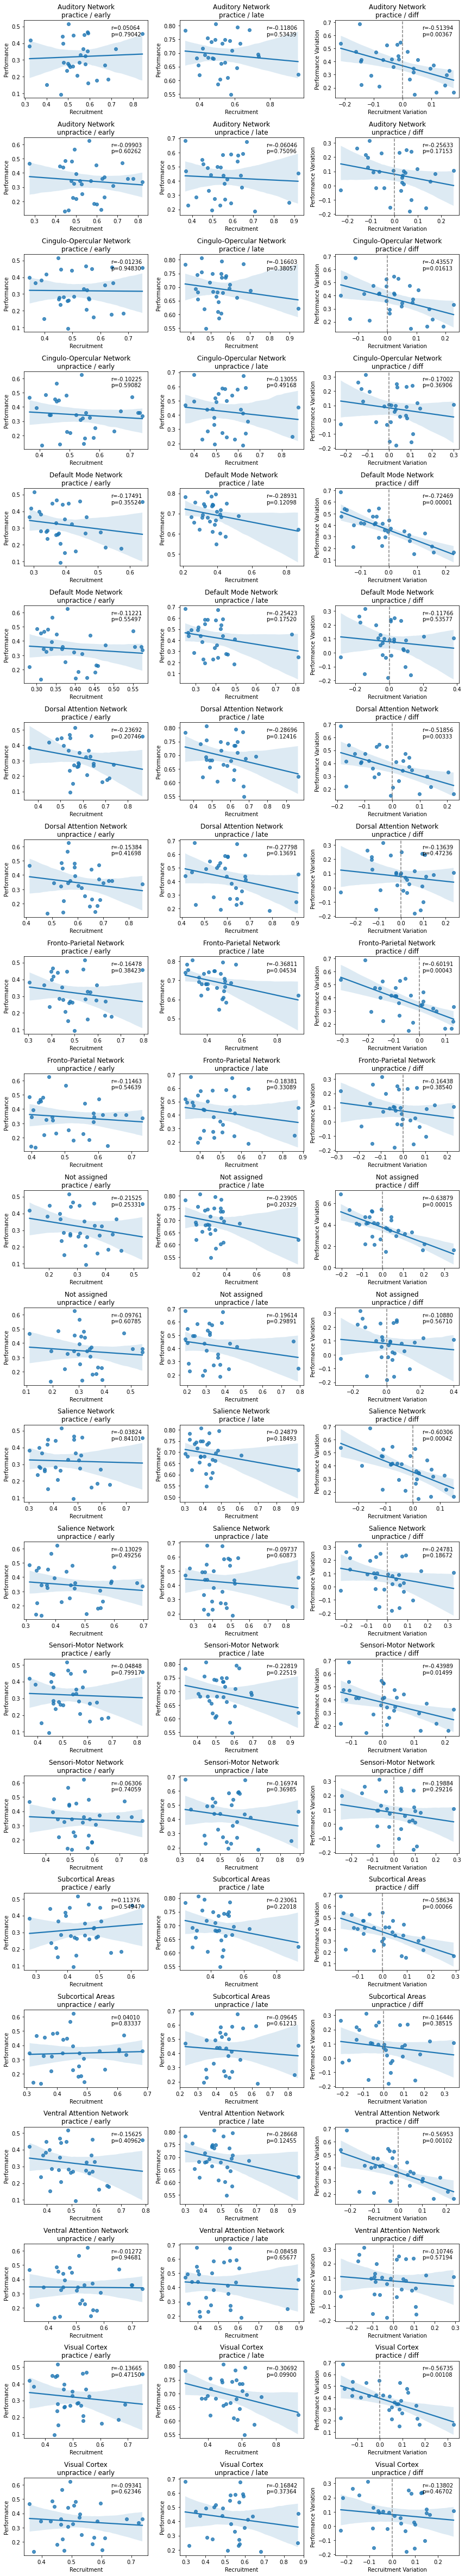

In [22]:
print(stat)

nrows = len(networks)*2
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3))

for mm, mapping in enumerate(['practice', 'unpractice']):
    R_p = np.mean(R[:,:,3*mm:3*(mm+1)], axis=2)
    behav_p = np.mean(behav[:,:,3*mm:3*(mm+1)], axis=2)
    for ii, network in enumerate(networks):
        row = 2*ii + mm
        idx = full_networks==network
        for col, visit in enumerate(['early', 'late', 'diff']):
            ax = axs[row,col]
            if visit == 'diff':
                x = R_p[1,:,ii] - R_p[0,:,ii]
                y = behav_p[1,:] - behav_p[0,:]
                xlabel = 'Recruitment Variation'
                ylabel = 'Performance Variation'
            else:
                x = R_p[col,:,ii]
                y = behav_p[col,:]
                xlabel = 'Recruitment'
                ylabel = 'Performance'

            title = '%s\n%s / %s'%(network, mapping, visit)
            ## Pearson coefficient
            X = x[~np.isnan(x)]
            Y = y[~np.isnan(x)]
            r, p = scipy.stats.pearsonr(X,Y)
            img = sns.regplot(
                x=X, y=Y, ax=ax
                , x_ci='ci'
            )
            img.set(
                title=title
                , xlabel=xlabel, ylabel=ylabel
            )
            x0, x1 = img.get_xlim()
            y0, y1 = img.get_ylim()
            img.text(x0+(x1-x0)*.7, y0+(y1-y0)*.8, s='r=%.5f\np=%.5f'%(r,p), fontsize=10)
            if x0<=0 and x1>=0:
                ax.axvline(x=0, color='gray', linestyle='--')
                
            if visit=='diff':
                ## null hypothesis mu=0 (two-Tailed t-Test)
                (t0, p0) = scipy.stats.ttest_1samp(X, popmean=0, alternative='two-sided')
                print(
                    "two-tailed t-test (%s / %s):\t"%(network, mapping)
                    , "p=%.3e (%s)"%(p0, convert_pvalue_to_asterisks(p0))
                )
                
fig.tight_layout()

GLM.MO
two-tailed t-test (Auditory Network / practice):	 p=7.438e-01 (ns)
two-tailed t-test (Cingulo-Opercular Network / practice):	 p=1.618e-01 (ns)
two-tailed t-test (Default Mode Network / practice):	 p=3.199e-01 (ns)
two-tailed t-test (Dorsal Attention Network / practice):	 p=3.237e-01 (ns)
two-tailed t-test (Fronto-Parietal Network / practice):	 p=1.145e-02 (*)
two-tailed t-test (Not assigned / practice):	 p=7.212e-01 (ns)
two-tailed t-test (Salience Network / practice):	 p=2.989e-01 (ns)
two-tailed t-test (Sensori-Motor Network / practice):	 p=8.214e-01 (ns)
two-tailed t-test (Subcortical Areas / practice):	 p=3.058e-01 (ns)
two-tailed t-test (Ventral Attention Network / practice):	 p=8.313e-01 (ns)
two-tailed t-test (Visual Cortex / practice):	 p=1.307e-01 (ns)
two-tailed t-test (Auditory Network / unpractice):	 p=8.356e-01 (ns)
two-tailed t-test (Cingulo-Opercular Network / unpractice):	 p=5.852e-01 (ns)
two-tailed t-test (Default Mode Network / unpractice):	 p=4.139e-01 (ns)
t

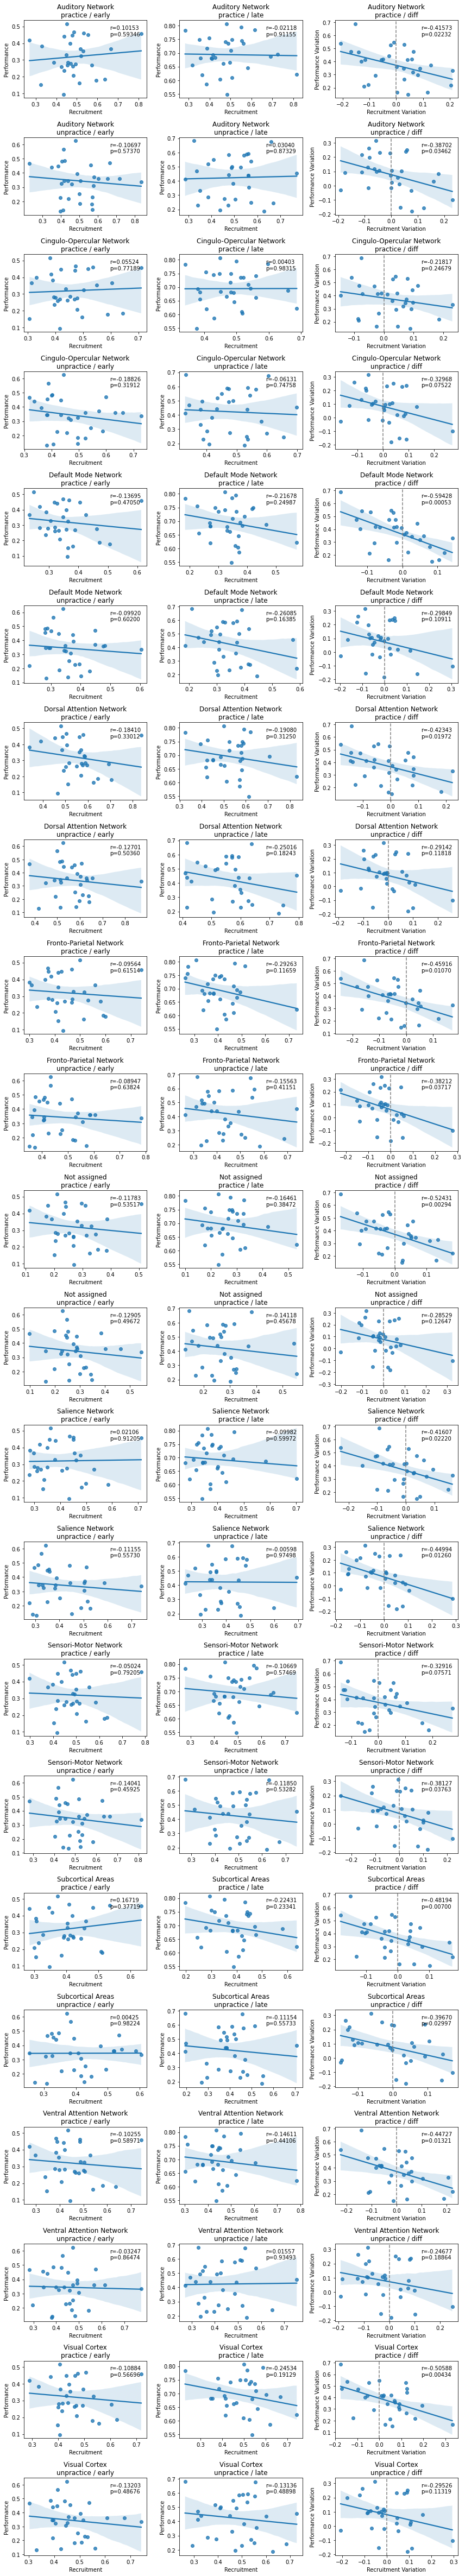

In [69]:
print(stat)

nrows = len(networks)*2
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3))

for mm, mapping in enumerate(['practice', 'unpractice']):
    R_p = np.mean(R[:,:,3*mm:3*(mm+1)], axis=2)
    behav_p = np.mean(behav[:,:,3*mm:3*(mm+1)], axis=2)
    for ii, network in enumerate(networks):
        row = 2*ii + mm
        idx = full_networks==network
        for col, visit in enumerate(['early', 'late', 'diff']):
            ax = axs[row,col]
            if visit == 'diff':
                x = R_p[1,:,ii] - R_p[0,:,ii]
                y = behav_p[1,:] - behav_p[0,:]
                xlabel = 'Recruitment Variation'
                ylabel = 'Performance Variation'
            else:
                x = R_p[col,:,ii]
                y = behav_p[col,:]
                xlabel = 'Recruitment'
                ylabel = 'Performance'

            title = '%s\n%s / %s'%(network, mapping, visit)
            ## Pearson coefficient
            X = x[~np.isnan(x)]
            Y = y[~np.isnan(x)]
            r, p = scipy.stats.pearsonr(X,Y)
            img = sns.regplot(
                x=X, y=Y, ax=ax
                , x_ci='ci'
            )
            img.set(
                title=title
                , xlabel=xlabel, ylabel=ylabel
            )
            x0, x1 = img.get_xlim()
            y0, y1 = img.get_ylim()
            img.text(x0+(x1-x0)*.7, y0+(y1-y0)*.8, s='r=%.5f\np=%.5f'%(r,p), fontsize=10)
            if x0<=0 and x1>=0:
                ax.axvline(x=0, color='gray', linestyle='--')
                
            if visit=='diff':
                ## null hypothesis mu=0 (two-Tailed t-Test)
                (t0, p0) = scipy.stats.ttest_1samp(X, popmean=0, alternative='two-sided')
                print(
                    "two-tailed t-test (%s / %s):\t"%(network, mapping)
                    , "p=%.3e (%s)"%(p0, convert_pvalue_to_asterisks(p0))
                )
                
fig.tight_layout()

In [25]:
fig.savefig(
    '/home/sungbeenpark/GA/network.regplot.corr-coef_behav.%s.Mohr264.png'%stat
    , dpi=300, bbox_inches = "tight"
)

---

In [26]:
print(R.shape)
df = pd.DataFrame(columns=['visit', 'subj', 'run', 'network', 'recruitment'])
row = 0
for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for rr, run in enumerate(list_run):
            for nn, network in enumerate(networks):
                df.loc[row] = [visit, subj, run, network, R[vv,ss,rr,nn]]
                row += 1
df

(2, 30, 6, 11)


visit subj  run                    network  recruitment
0     early   01  r01           Auditory Network     0.600413
1     early   01  r01  Cingulo-Opercular Network     0.497826
2     early   01  r01       Default Mode Network     0.394787
3     early   01  r01   Dorsal Attention Network     0.513338
4     early   01  r01    Fronto-Parietal Network     0.473426
...     ...  ...  ...                        ...          ...
3955   late   44  r06           Salience Network     0.375952
3956   late   44  r06      Sensori-Motor Network     0.547227
3957   late   44  r06          Subcortical Areas     0.519739
3958   late   44  r06  Ventral Attention Network     0.475960
3959   late   44  r06              Visual Cortex     0.592034

[3960 rows x 5 columns]

GLM.RO


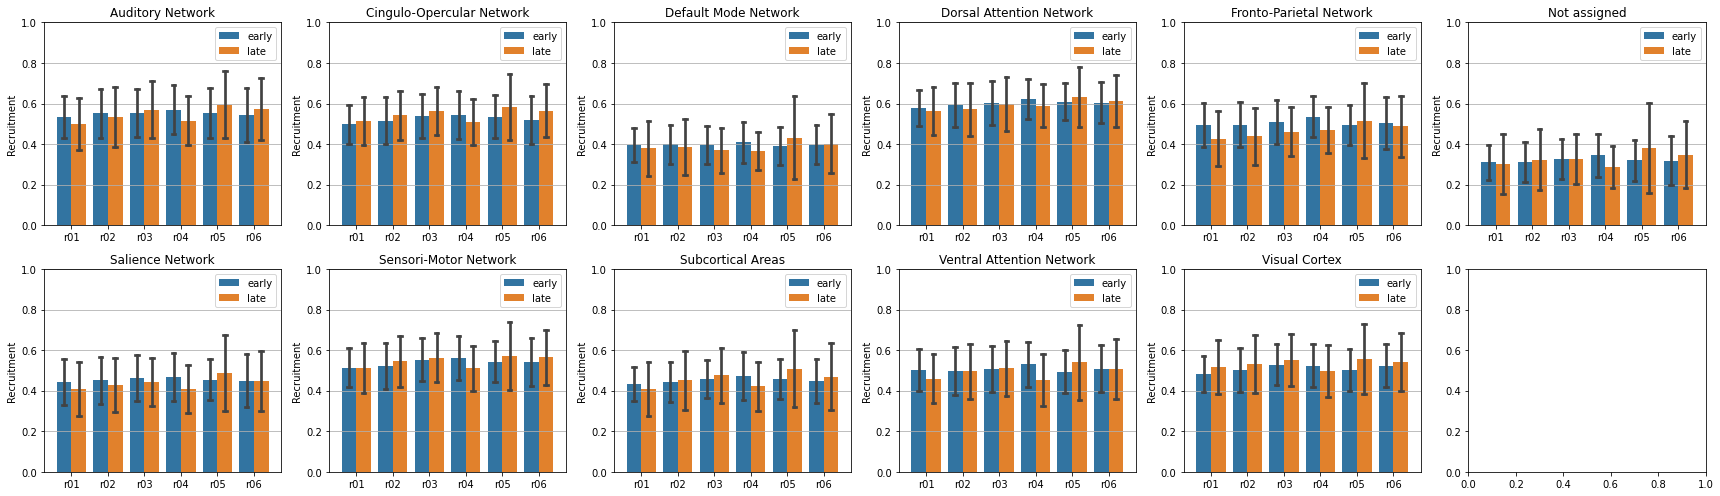

In [27]:
print(stat)

# nrows, ncols = 1, len(networks)
nrows, ncols = 2, 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.5))
axs = np.concatenate(axs)

for ii, network in enumerate(networks):
    ax = axs[ii]
    
    data = df[df.network==network]
    x='run'
    y='recruitment'
    hue='visit'
    
    ax = sns.barplot(
        data=data
        , x=x, y=y, hue=hue
        , capsize=.1, ci='sd', ax=ax
    )
    ax.set(
        title=network
        , xlim=(-.75,5.75)
        , xlabel=None
        , ylim=(0., 1.), ylabel='Recruitment'
    )
    ax.grid(axis='y')
    ax.legend(loc='upper right')
#     if ii<10:
#         ax.legend().remove()
#     else:
#         ax.legend(
#             fontsize=14, frameon=True
#             , bbox_to_anchor=(1.04,0.5), loc="center left"
#             , borderaxespad=0
#         )
    
#     ## paried t-test
#     A = data[(data.visit=='early')&(data.run=='practice')].recruitment
#     B = data[(data.visit=='late')&(data.run=='practice')].recruitment
#     isntnan = (~np.isnan(A.values))*(~np.isnan(B.values))
#     tval, pval = scipy.stats.ttest_rel(A[isntnan],B[isntnan])
#     symbol = convert_pvalue_to_asterisks(pval)
#     print('%s(practice): %.3e (%s)'%(network, pval, symbol))
#     A = data[(data.visit=='early')&(data.run=='unpractice')].recruitment
#     B = data[(data.visit=='late')&(data.run=='unpractice')].recruitment
#     tval, pval = scipy.stats.ttest_rel(A[isntnan],B[isntnan])
#     symbol = convert_pvalue_to_asterisks(pval)
#     print('%s(unpractice): %.3e (%s)'%(network, pval, symbol))

# ## statistical annotation
# ep = 0.2
# ### DMN
# ax = axs[0]
# data = df[df.network=='DMN']
# #### practice
# x1, x2 = 0-ep, 1-ep # columns 'early' and 'late' (first column: 0, see plt.xticks())
# A = data[(data.visit=='early')&(data.run=='practice')].recruitment
# B = data[(data.visit=='late')&(data.run=='practice')].recruitment
# y0, h = max(A.mean()+A.std(), B.mean()+B.std())+.05, 0.04
# ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1.5, c='k')
# ax.text(
#     (x1+x2)*.5, y0+h
#     , '*'
#     , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
# )

fig.tight_layout()

GLM.MO


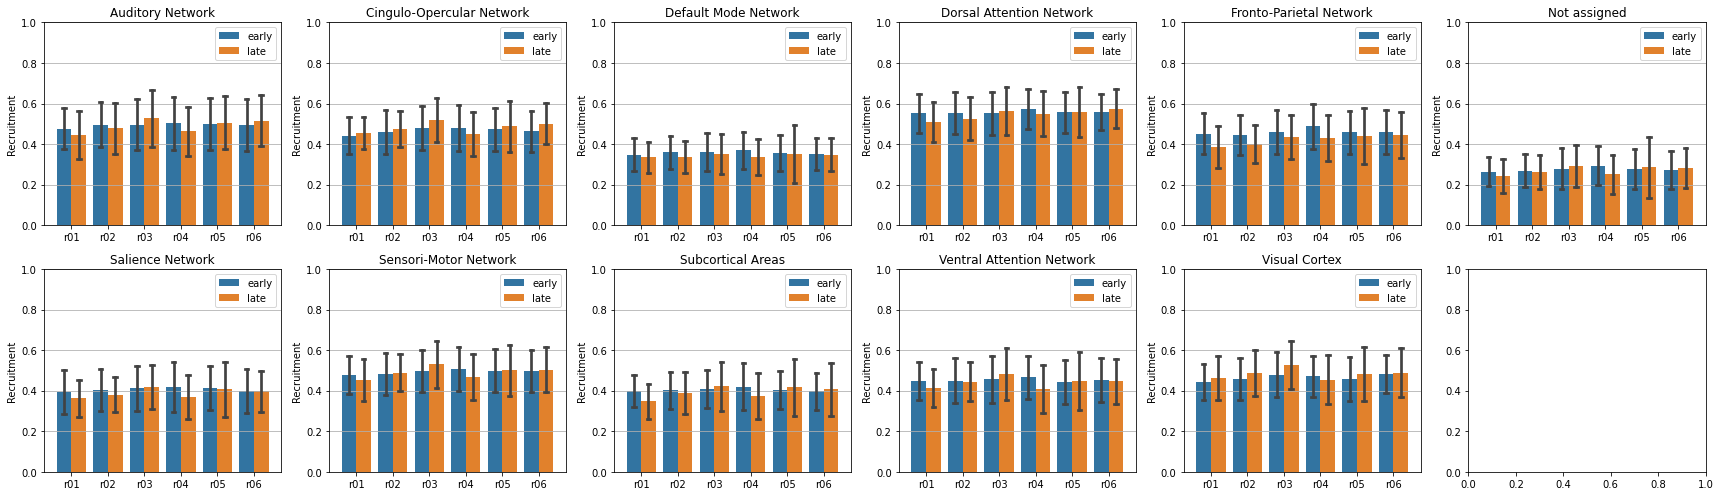

In [71]:
print(stat)

# nrows, ncols = 1, len(networks)
nrows, ncols = 2, 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.5))
axs = np.concatenate(axs)

for ii, network in enumerate(networks):
    ax = axs[ii]
    
    data = df[df.network==network]
    x='run'
    y='recruitment'
    hue='visit'
    
    ax = sns.barplot(
        data=data
        , x=x, y=y, hue=hue
        , capsize=.1, ci='sd', ax=ax
    )
    ax.set(
        title=network
        , xlim=(-.75,5.75)
        , xlabel=None
        , ylim=(0., 1.), ylabel='Recruitment'
    )
    ax.grid(axis='y')
    ax.legend(loc='upper right')
#     if ii<10:
#         ax.legend().remove()
#     else:
#         ax.legend(
#             fontsize=14, frameon=True
#             , bbox_to_anchor=(1.04,0.5), loc="center left"
#             , borderaxespad=0
#         )
    
#     ## paried t-test
#     A = data[(data.visit=='early')&(data.run=='practice')].recruitment
#     B = data[(data.visit=='late')&(data.run=='practice')].recruitment
#     isntnan = (~np.isnan(A.values))*(~np.isnan(B.values))
#     tval, pval = scipy.stats.ttest_rel(A[isntnan],B[isntnan])
#     symbol = convert_pvalue_to_asterisks(pval)
#     print('%s(practice): %.3e (%s)'%(network, pval, symbol))
#     A = data[(data.visit=='early')&(data.run=='unpractice')].recruitment
#     B = data[(data.visit=='late')&(data.run=='unpractice')].recruitment
#     tval, pval = scipy.stats.ttest_rel(A[isntnan],B[isntnan])
#     symbol = convert_pvalue_to_asterisks(pval)
#     print('%s(unpractice): %.3e (%s)'%(network, pval, symbol))

# ## statistical annotation
# ep = 0.2
# ### DMN
# ax = axs[0]
# data = df[df.network=='DMN']
# #### practice
# x1, x2 = 0-ep, 1-ep # columns 'early' and 'late' (first column: 0, see plt.xticks())
# A = data[(data.visit=='early')&(data.run=='practice')].recruitment
# B = data[(data.visit=='late')&(data.run=='practice')].recruitment
# y0, h = max(A.mean()+A.std(), B.mean()+B.std())+.05, 0.04
# ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1.5, c='k')
# ax.text(
#     (x1+x2)*.5, y0+h
#     , '*'
#     , ha='center', va='bottom', fontdict={'fontsize': 20, 'color': 'k'}
# )

fig.tight_layout()

In [179]:
fig.savefig(
    '/home/sungbeenpark/GA/network.barplots.recruitment.%s.Mohr264.png'%stat
    , dpi=300, bbox_inches = "tight"
)

---

- Global signal

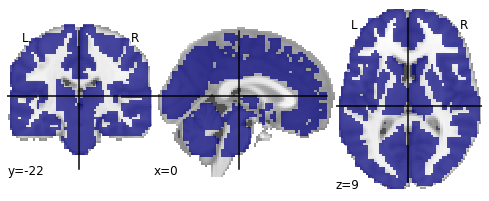

In [25]:
mask_GM = join('/mnt/sda2/GA/fmri_data/masks/fan280/fan.roi.GA.all.nii')
nplt.plot_roi(mask_GM)

In [47]:
with open(join(dir_root, 'tsmean/Mohr264/time_series.pb04.errts_tproject.global_from_fan280.pkl'), 'rb') as f:
    global_activity = pickle.load(f)

- Performance vs. Integration

In [176]:
## Iecruitment, 2 days, 30 subjects, 6 runs, 3 networks
I = np.ones((2,30,6,len(networks))) * np.nan

for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for rr, run in enumerate(list_run):
            integration = calc_integration(adjacency[vv,ss,rr], full_networks)
            for nn, network in enumerate(networks):
                I[vv,ss,rr,nn] = np.mean(integration[full_networks==network])
I.shape

(2, 30, 6, 11)

In [46]:
df = pd.DataFrame(columns=['visit', 'subj', 'mapping', 'network', 'integration'])
row = 0
for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for mm, mapping in enumerate(['practice', 'unpractice']):
            for nn, network in enumerate(networks):
                df.loc[row] = [visit, subj, mapping, network, mean_I[vv,ss,mm,nn]]
                row += 1
df

visit subj     mapping      network  integration
0    early   01    practice          DMN     0.508037
1    early   01    practice  somatomotor     0.565185
2    early   01    practice       vision     0.561192
3    early   01  unpractice          DMN     0.644593
4    early   01  unpractice  somatomotor     0.680334
..     ...  ...         ...          ...          ...
355   late   44    practice  somatomotor     0.394307
356   late   44    practice       vision     0.417753
357   late   44  unpractice          DMN     0.379423
358   late   44  unpractice  somatomotor     0.442369
359   late   44  unpractice       vision     0.468549

[360 rows x 5 columns]

DMN(practice): 9.390e-02 (ns)
DMN(unpractice): 6.605e-02 (ns)


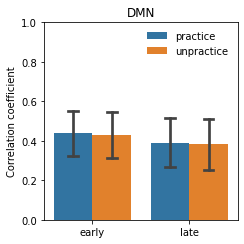

In [48]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3.5, nrows*3.5))

# for ii, network in enumerate(networks):
#     ax = axs[ii]
for ii, network in enumerate(['DMN']):
    ax = axs
    
    data = df[df.network==network]
    x='visit'
    y='integration'
    hue='mapping'
    
    ax = sns.barplot(
        data=data
        , x=x, y=y, hue=hue
        , capsize=.1, ci='sd', ax=ax
    )
    ax.set(
        title=network
        , xlim=(-.5,1.5), xlabel=None
        , ylim=(0., 1.), ylabel='Correlation coefficient'
    )
    ax.legend(loc='upper right', fontsize=10, frameon=False)
    
    ## paried t-test
    A = data[(data.visit=='early')&(data.mapping=='practice')].integration
    B = data[(data.visit=='late')&(data.mapping=='practice')].integration
    isntnan = (~np.isnan(A.values))*(~np.isnan(B.values))
    tval, pval = scipy.stats.ttest_rel(A[isntnan],B[isntnan])
    symbol = convert_pvalue_to_asterisks(pval)
    print('%s(practice): %.3e (%s)'%(network, pval, symbol))
    A = data[(data.visit=='early')&(data.mapping=='unpractice')].integration
    B = data[(data.visit=='late')&(data.mapping=='unpractice')].integration
    tval, pval = scipy.stats.ttest_rel(A[isntnan],B[isntnan])
    symbol = convert_pvalue_to_asterisks(pval)
    print('%s(unpractice): %.3e (%s)'%(network, pval, symbol))
    
fig.tight_layout()

In [49]:
fig.savefig('/home/sungbeenpark/GA/network.barplot.corr-coef.DMN-others.png', dpi=300)

- Integration between `somatomotor` ans `visual` area

In [50]:
## Somatomotor-Vision integration: 2 days, 30 subjects, 6 runs, 2 networks
I = np.ones((2,30,6,2)) * np.nan

visuomotor = staticcommunity!='DMN'
tmp = adjacency[:,:,:,:,visuomotor]
tmp = tmp[:,:,:,visuomotor,:]
print(tmp.shape)

(2, 30, 6, 67, 67)


In [51]:
for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for rr, run in enumerate(list_run):
            integration = calc_integration(tmp[vv,ss,rr], staticcommunity[visuomotor])
            for nn, network in enumerate(['somatomotor', 'vision']):
                I[vv,ss,rr,nn] = np.mean(integration[staticcommunity[visuomotor]==network])
                
## 6 runs(r01, r02, ..., r06) -> 2 maps(practice, unpractice)
mean_I = np.ones((2,30,2,2)) * np.nan
for mm, mapping in enumerate(['practice', 'unpractice']):
    mean_I[:,:,mm,:] = np.nanmean(I[:,:,3*mm:3*(mm+1)], axis=2)

/tmp/ipykernel_356042/1015756446.py:19: RuntimeWarning: Mean of empty slice
  integration[node] = np.nanmean(A[node, S!=network])


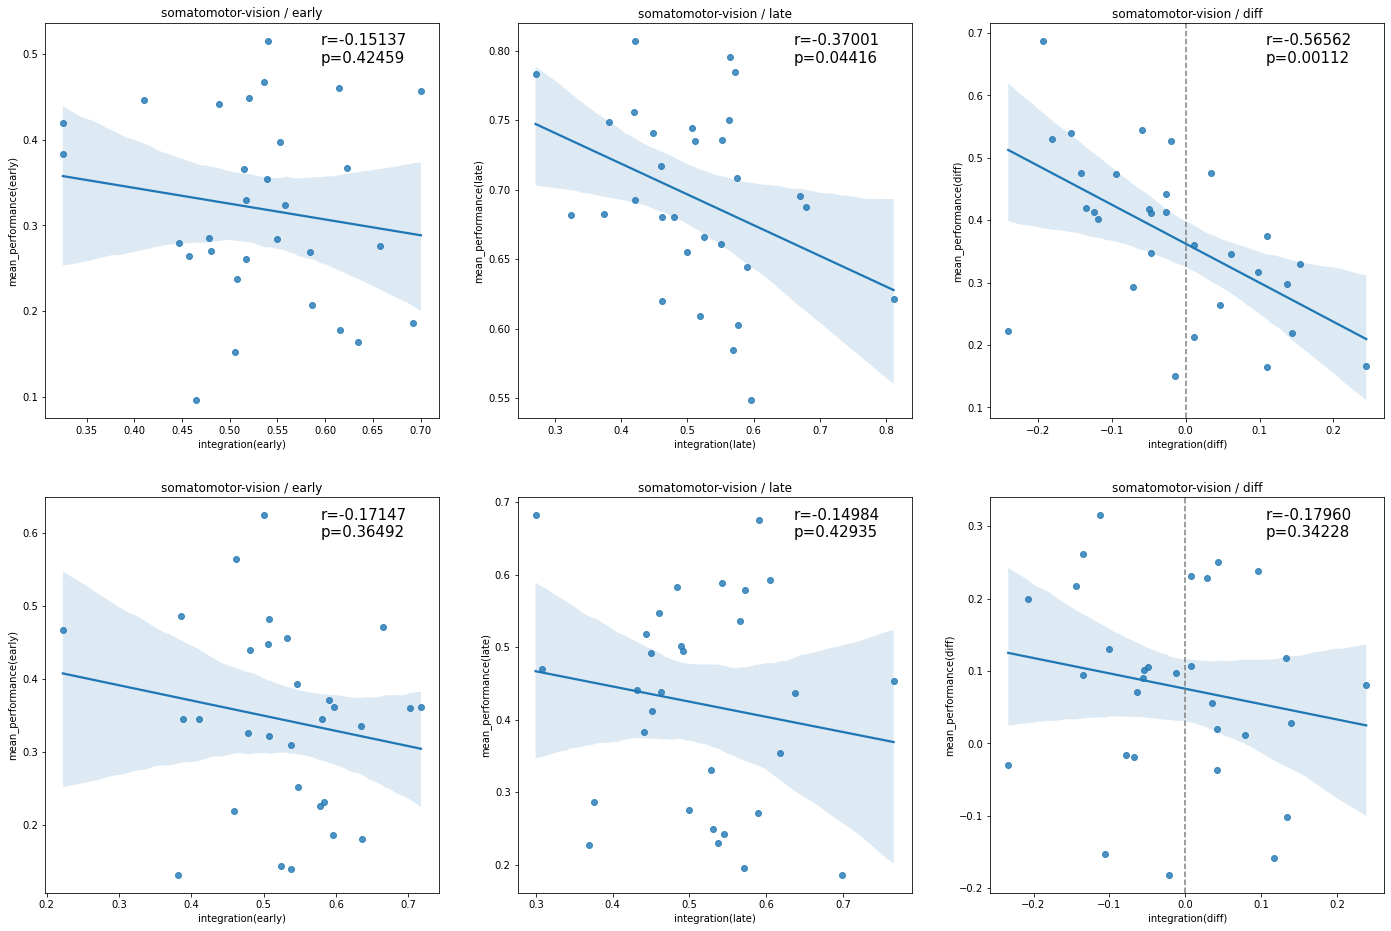

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3*8, 2*8))

for mm, mapping in enumerate(['practice', 'unpractice']):
    mean_performance = np.nanmean(performance[:,:,3*mm:3*(mm+1)], axis=2)
    mean_I = np.nanmean(I[:,:,3*mm:3*(mm+1)], axis=2)
    ## somatomotor 와 vision 밖에 없으므로, integration 은 같음. 즉 둘 중 하나만 고려하면 됨.
    for ii, network in enumerate(['somatomotor']):
        row = mm + ii
        idx = staticcommunity==network
        for col, visit in enumerate(['early', 'late', 'diff']):
            ax = axs[row,col]
            if visit == 'diff':
                x = mean_I[1,:,ii] - mean_I[0,:,ii]
                y = mean_performance[1,:] - mean_performance[0,:]
            else:
                x = mean_I[col,:,ii]
                y = mean_performance[col,:]

            X = x[~np.isnan(x)]
            Y = y[~np.isnan(x)]
            r, p = scipy.stats.pearsonr(X,Y)
            img = sns.regplot(
                x=X, y=Y, ax=ax
                , x_ci='ci'
            )
            ## Lower-Tailed t-Test
            img.set(
                title='somatomotor-vision / %s'%(visit)
                , xlabel='integration(%s)'%visit, ylabel='mean_performance(%s)'%visit
            )
            x0, x1 = img.get_xlim()
            y0, y1 = img.get_ylim()
            img.text(x0+(x1-x0)*.7, y0+(y1-y0)*.9, s='r=%.5f\np=%.5f'%(r,p), fontsize=15)
            if x0<=0 and x1>=0:
                ax.axvline(x=0, color='gray', linestyle='--')

two-tailed t-test (practice):	 p=0.37183
two-tailed t-test (unpractice):	 p=0.47414


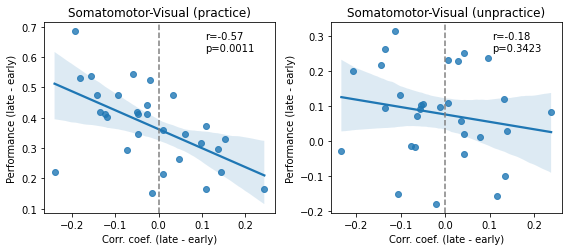

In [52]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.6))
if len(axs.shape)>1:
    axs = np.concatenate(axs)

for mm, mapping in enumerate(['practice', 'unpractice']):
    ## normalize (divided by a sum of the recruitment)
#     mean_I = mean_I / mean_R[:,:,:2]
    ## somatomotor 와 vision 밖에 없으므로, integration 은 같음. 즉 둘 중 하나만 고려하면 됨.
    for ii, network in enumerate(['somatomotor']):
        ax = axs[2*ii+mm]
        idx = staticcommunity==network
        ## late - early
        x = mean_I[1,:,mm,ii] - mean_I[0,:,mm,ii]
        y = mean_performance[1,:,mm] - mean_performance[0,:,mm]

        ## Pearson's coefficient
        X = x[~np.isnan(x)]
        Y = y[~np.isnan(x)]
        r, p = scipy.stats.pearsonr(X,Y)
        img = sns.regplot(x=X, y=Y, x_ci='ci', ax=ax)
        img.set(
            title='Somatomotor-Visual (%s)'%(mapping)
            , xlabel='Corr. coef. (late - early)', ylabel='Performance (late - early)'
        )
        
        ## null hypothesis mu=0 (two-Tailed t-Test)
        (t0, p0) = scipy.stats.ttest_1samp(X, popmean=0, alternative='two-sided')
        print("two-tailed t-test (%s):\t"%mapping, "p=%.5f"%p0)
        
        ## insert text
        x0, x1 = img.get_xlim()
        y0, y1 = img.get_ylim()
        img.text(x0+(x1-x0)*.7, y0+(y1-y0)*.85, s='r=%.2f\np=%.4f'%(r,p), fontsize=10)
        
        ## line (x=0)
        if x0<=0 and x1>=0:
            ax.axvline(x=0, color='gray', linestyle='--')

fig.tight_layout()

In [53]:
fig.savefig('/home/sungbeenpark/GA/network.regplot.corr-coef_behav.somatomotor-visual.png', dpi=300)

In [54]:
df = pd.DataFrame(columns=['visit', 'subj', 'mapping', 'network', 'integration'])
row = 0
for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for mm, mapping in enumerate(['practice', 'unpractice']):
            for nn, network in enumerate(['somatomotor', 'vision']):
                df.loc[row] = [visit, subj, mapping, network, mean_I[vv,ss,mm,nn]]
                row += 1
df

visit subj     mapping      network  integration
0    early   01    practice  somatomotor     0.622436
1    early   01    practice       vision     0.622436
2    early   01  unpractice  somatomotor     0.702658
3    early   01  unpractice       vision     0.702658
4    early   02    practice  somatomotor     0.410470
..     ...  ...         ...          ...          ...
235   late   42  unpractice       vision     0.571785
236   late   44    practice  somatomotor     0.480382
237   late   44    practice       vision     0.480382
238   late   44  unpractice  somatomotor     0.537398
239   late   44  unpractice       vision     0.537398

[240 rows x 5 columns]

somatomotor(practice): 3.718e-01 (ns)
somatomotor(unpractice): 4.741e-01 (ns)


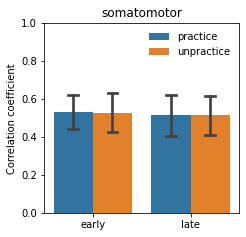

In [56]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3.5, nrows*3.5))

# for ii, network in enumerate(networks):
#     ax = axs[ii]
for ii, network in enumerate(['somatomotor']):
    ax = axs
    
    data = df[df.network==network]
    x='visit'
    y='integration'
    hue='mapping'
    
    ax = sns.barplot(
        data=data
        , x=x, y=y, hue=hue
        , capsize=.1, ci='sd', ax=ax
    )
    ax.set(
        title=network
        , xlim=(-.5,1.5), xlabel=None
        , ylim=(0., 1.), ylabel='Correlation coefficient'
    )
    ax.legend(loc='upper right', fontsize=10, frameon=False)
    
    ## paried t-test
    A = data[(data.visit=='early')&(data.mapping=='practice')].integration
    B = data[(data.visit=='late')&(data.mapping=='practice')].integration
    isntnan = (~np.isnan(A.values))*(~np.isnan(B.values))
    tval, pval = scipy.stats.ttest_rel(A[isntnan],B[isntnan])
    symbol = convert_pvalue_to_asterisks(pval)
    print('%s(practice): %.3e (%s)'%(network, pval, symbol))
    A = data[(data.visit=='early')&(data.mapping=='unpractice')].integration
    B = data[(data.visit=='late')&(data.mapping=='unpractice')].integration
    tval, pval = scipy.stats.ttest_rel(A[isntnan],B[isntnan])
    symbol = convert_pvalue_to_asterisks(pval)
    print('%s(unpractice): %.3e (%s)'%(network, pval, symbol))


In [57]:
fig.savefig('/home/sungbeenpark/GA/network.barplot.corr-coef.somatomotor-visual.png', dpi=300)

---

In [31]:
## integration: 2 days, 30 subjects, 6 runs, 2 networks(somatomotor-vision)
print(I.shape)
df = pd.DataFrame(columns=['visit','subj','mapping','M-V integration'])

row = 0
for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for mm, mapping in enumerate(['practice', 'unpractice']):
            integ = np.nanmean(I[vv,ss,3*mm:3*(mm+1),0])
            df.loc[row] = [visit, subj, mapping, integ]
            row += 1
df

(2, 30, 6, 2)


visit subj     mapping  M-V integration
0    early   01    practice         0.622436
1    early   01  unpractice         0.702658
2    early   02    practice         0.410470
3    early   02  unpractice         0.388033
4    early   05    practice         0.552916
..     ...  ...         ...              ...
115   late   38  unpractice         0.528230
116   late   42    practice         0.461552
117   late   42  unpractice         0.571785
118   late   44    practice         0.480382
119   late   44  unpractice         0.537398

[120 rows x 4 columns]

<AxesSubplot:xlabel='visit', ylabel='M-V integration'>

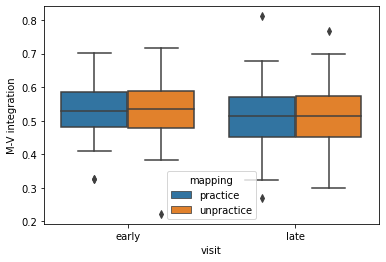

In [32]:
sns.boxplot(data=df, x='visit', y='M-V integration', hue='mapping')

## 3. Network Measures

### ⅰ) Communities (using Genlouvain.m)

In [14]:
condition = 'node=103.wpr=8.r=1.w=1.iter=100'

genlouvain_result = scipy.io.loadmat('/home/sungbeenpark/GA/GenLouvain/community.%s.mat'%condition)
communities = genlouvain_result['communities']
print(communities.shape)
Qs = genlouvain_result['Qs']
print(Qs.shape)
niter = communities.shape[1]

keys = np.array(genlouvain_result['key'], dtype='U4')
# keys = np.empty(np.array(list(tsmean_genuine.keys())).shape, dtype='U4')
# for i, (subj, run) in enumerate(tsmean_genuine.keys()):
#     keys[i,:] = str(subj), str(run)
# print(keys.shape)

(355, 100, 103, 8)
(355, 100)


In [152]:
# ## 초기조건에 따른 Q값의 변화 폭 그려보기
# df = pd.DataFrame(columns=['key', 'iter', 'modularities'])

# row = 0
# for i, (ggnn, run) in enumerate(keys):
#     key = ggnn+run
#     for j, Q in enumerate(Qs[i]):
#         df.loc[row] = [key, j, Q]
#         row += 1

# fig, axs = plt.subplots(figsize=(40, 20))

# ax = axs
# sns.boxplot(data=df, x='key', y='modularities', ax=ax)
# ax.set_xlabel('key', fontsize=40)
# ax.set_ylabel('Modularity', fontsize=40)
# ax.set_xticklabels('')

# fig.savefig('/home/sungbeenpark/GA/GenLouvain/Modularity.boxplot.png', dpi=300)

In [133]:
# ## 계산 오류값(NaN)이 없는지 확인
# for i, key in enumerate(keys):
#     print(key, communities[i].sum())

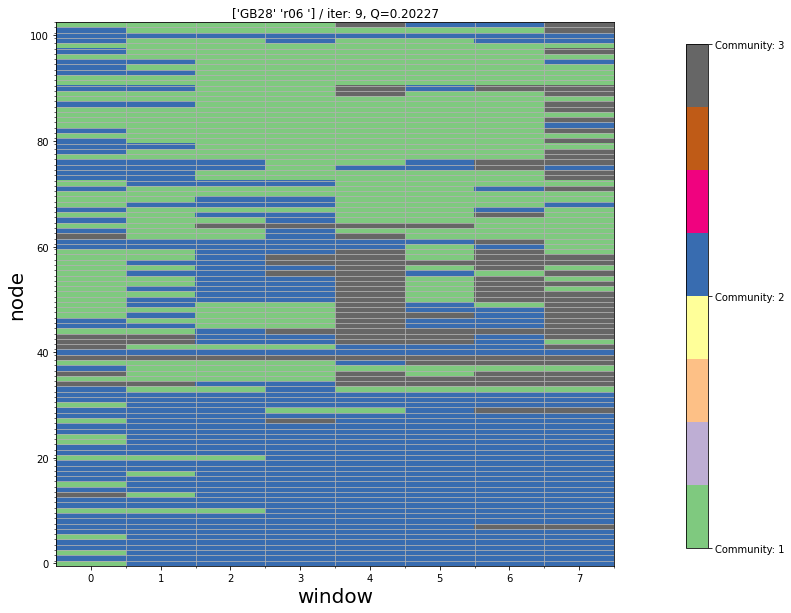

In [35]:
## 샘플로 네트워크를 그려보기
ii = np.random.choice(range(355))
jj = np.argmax(Qs[ii])
community = communities[ii]

_, N, T = community.shape

fig, axs = plt.subplots(figsize=(10,10))

ax = axs
img = ax.imshow(community[jj], cmap='Accent', interpolation=None, aspect='auto', origin='lower')
ax.set_xlabel('window', fontsize = 20)
ax.set_ylabel('node', fontsize = 20)
ax.set_title('%s / iter: %s, Q=%.5f'%(keys[ii],jj,Qs[ii,jj]))
ax.set_xticks(np.arange(T)+.5, minor=True)
ax.set_yticks(np.arange(N)+.5, minor=True)
ax.grid(axis='both', which='minor')

cax = fig.add_axes([1.0, .15, .03, .7])
cbar = fig.colorbar(img, cax=cax, ticks=[1,2,3], format='Community: %d')
cbar.ax.tick_params(labelsize=10)

### ⅱ) Module Allegiance Matrix

In [17]:
## (피험자, RUN) 별로 Module Allegiance Matrix 를 정리
import teneto.communitymeasures

## (2 days, 30 subjects, 6 runs, 103 nodes, 103 nodes)
allegiances = np.ones((2, 30, 6, 103, 103)) * np.nan

for ii, (ggnn, rr) in enumerate(tqdm(keys)):
    gg, nn = ggnn[:2], ggnn[2:]
    ## 피험자는 총 30*2명 (GA, GB 따로)
    idx_nn = np.where(np.array(list_subj)==nn)[0][0]
    ## GA('early') vs. GB('late')
    idx_gg = 0 if gg=='GA' else (1 if gg=='GB' else 'invalid')
    ## 'practice': r01-r03, 'unpractice': r04-r06
    idx_rr = np.where(np.array(list_run)==rr.strip())[0][0]

    ## modularity Q가 가장 큰 community에 대한 MA 만을 계산. 대각성분은 nan 임.
    jj = np.argmax(Qs[ii])
    allegiances[idx_gg, idx_nn, idx_rr, :, :] = teneto.communitymeasures.allegiance(communities[ii,jj])
    
#     tmp = np.ones((niter, nnodes, nnodes)) * np.nan
#     ## niter 개의 MA를 평균. 대각성분은 nan 임.
#     for jj in range(niter):
#         tmp[j] = teneto.communitymeasures.allegiance(communities[ii,jj])
#     allegiances[idx_gg, idx_nn, idx_rr, :, :] = np.mean(tmp, axis=0)

# ## save the result
# with open('/home/sungbeenpark/GA/GenLouvain/allegiance.%s.npy'%condition, 'wb') as f:
#     np.save(f, allegiances)

100%|██████████| 355/355 [00:17<00:00, 20.30it/s]


In [10]:
# with open('/home/sungbeenpark/GA/GenLouvain/allegiance.%s.npy'%condition, 'rb') as f:
#     allegiances = np.load(f)
# allegiances.shape

(2, 30, 6, 103, 103)

/tmp/ipykernel_48588/936041093.py:2: RuntimeWarning: Mean of empty slice
  mean_MA_by_run = np.nanmean(allegiances[0], axis=0)
/tmp/ipykernel_48588/936041093.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


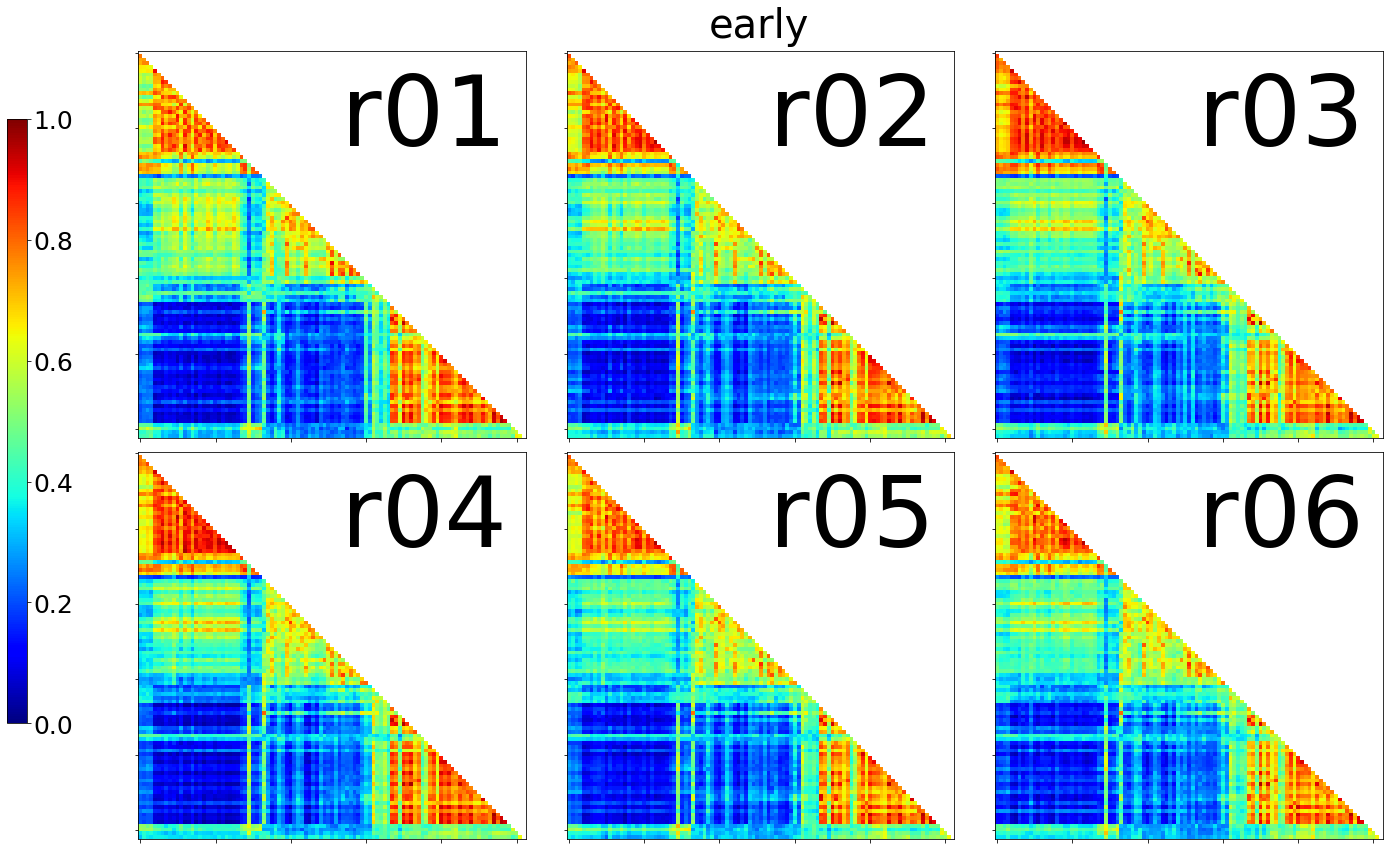

In [18]:
## GA
mean_MA_by_run = np.nanmean(allegiances[0], axis=0)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
axs = np.concatenate(axs)

for r, run in enumerate(list_run):
    ax = axs[r]
    img = nplt.plot_matrix(
        mat=mean_MA_by_run[r]
        , tri='lower'
        , cmap='jet', vmax=1, vmin=0., colorbar=False
        , axes=ax
        , title=run
    )
fig.suptitle('early', size=40)

cax = fig.add_axes([-.08, .15, .015, .7])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=25)

fig.tight_layout()

/tmp/ipykernel_48588/15322953.py:2: RuntimeWarning: Mean of empty slice
  mean_MA_by_run = np.nanmean(allegiances[1], axis=0)
/tmp/ipykernel_48588/15322953.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


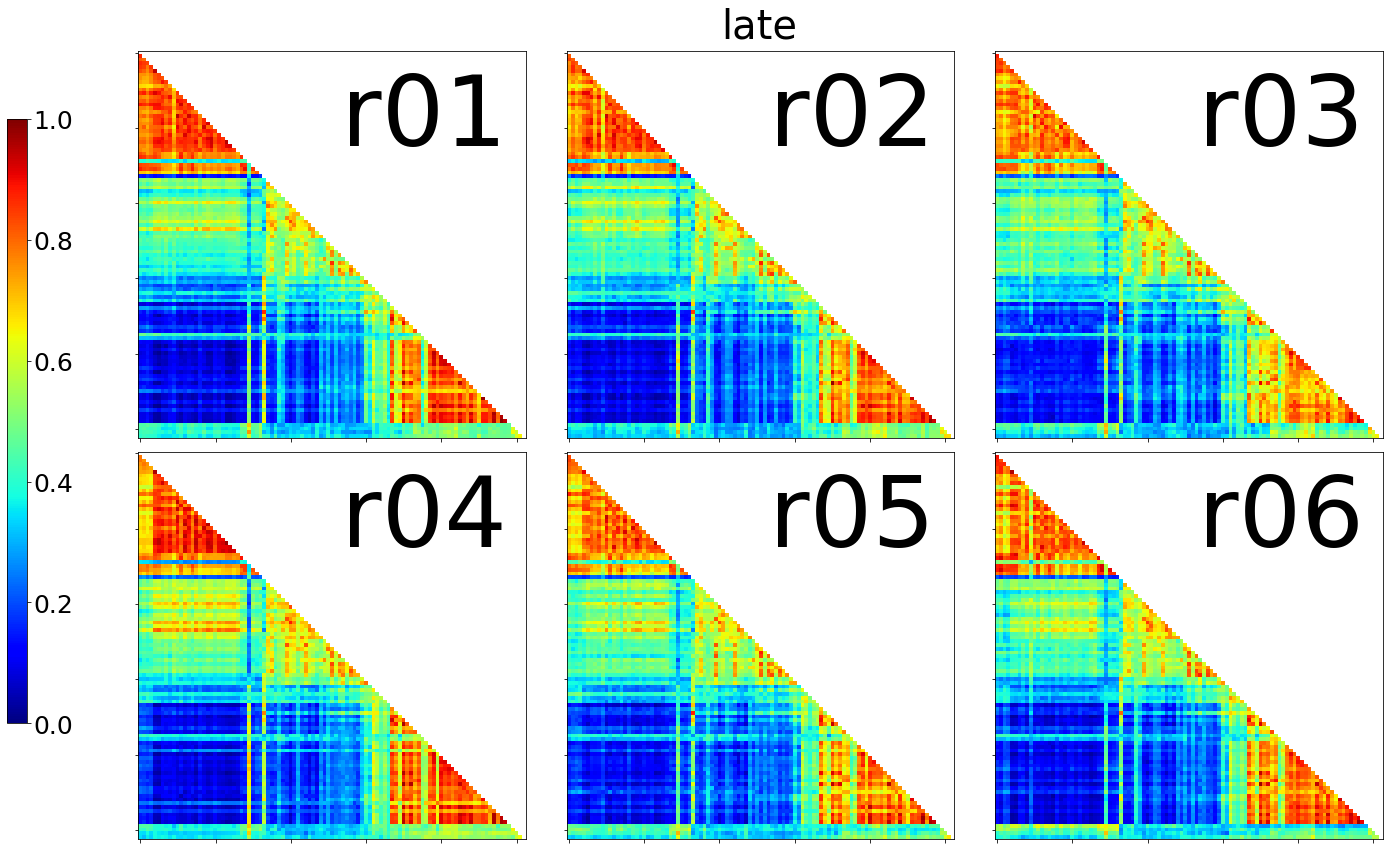

In [19]:
## GB
mean_MA_by_run = np.nanmean(allegiances[1], axis=0)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
axs = np.concatenate(axs)

for r, run in enumerate(list_run):
    ax = axs[r]
    img = nplt.plot_matrix(
        mat=mean_MA_by_run[r]
        , tri='lower'
        , cmap='jet', vmax=1, vmin=0., colorbar=False
        , axes=ax
        , title=run
    )
fig.suptitle('late', size=40)

cax = fig.add_axes([-.08, .15, .015, .7])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=25)

fig.tight_layout()

/tmp/ipykernel_48588/1433346425.py:2: RuntimeWarning: Mean of empty slice
  mean_MA_by_run = np.nanmean(allegiances[0]-allegiances[1], axis=0)
/tmp/ipykernel_48588/1433346425.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


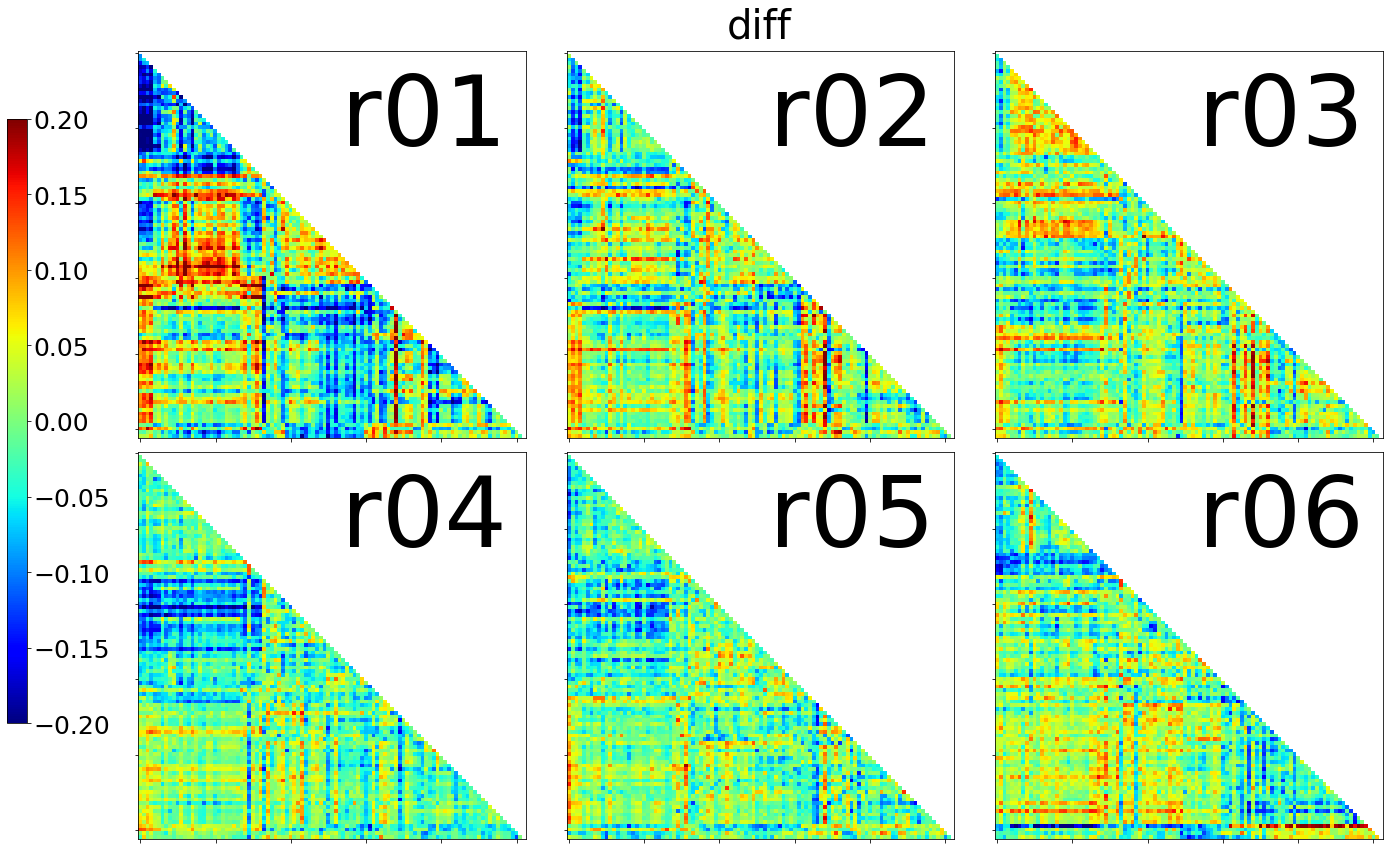

In [20]:
## GB - GA
mean_MA_by_run = np.nanmean(allegiances[0]-allegiances[1], axis=0)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
axs = np.concatenate(axs)

for r, run in enumerate(list_run):
    ax = axs[r]
    img = nplt.plot_matrix(
        mat=mean_MA_by_run[r]
        , tri='lower'
        , cmap='jet', vmax=.2, vmin=-.2, colorbar=False
        , axes=ax
        , title=run
    )
fig.suptitle('diff', size=40)

cax = fig.add_axes([-.08, .15, .015, .7])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=25)

fig.tight_layout()

/tmp/ipykernel_48588/1945339067.py:14: RuntimeWarning: Mean of empty slice
  matrix = np.nanmean(allegiances[i,:,:3], axis=(0,1))
/tmp/ipykernel_48588/1945339067.py:9: RuntimeWarning: Mean of empty slice
  matrix = np.nanmean(allegiances[1,:,:3]-allegiances[0,:,:3], axis=(0,1))
/tmp/ipykernel_48588/1945339067.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


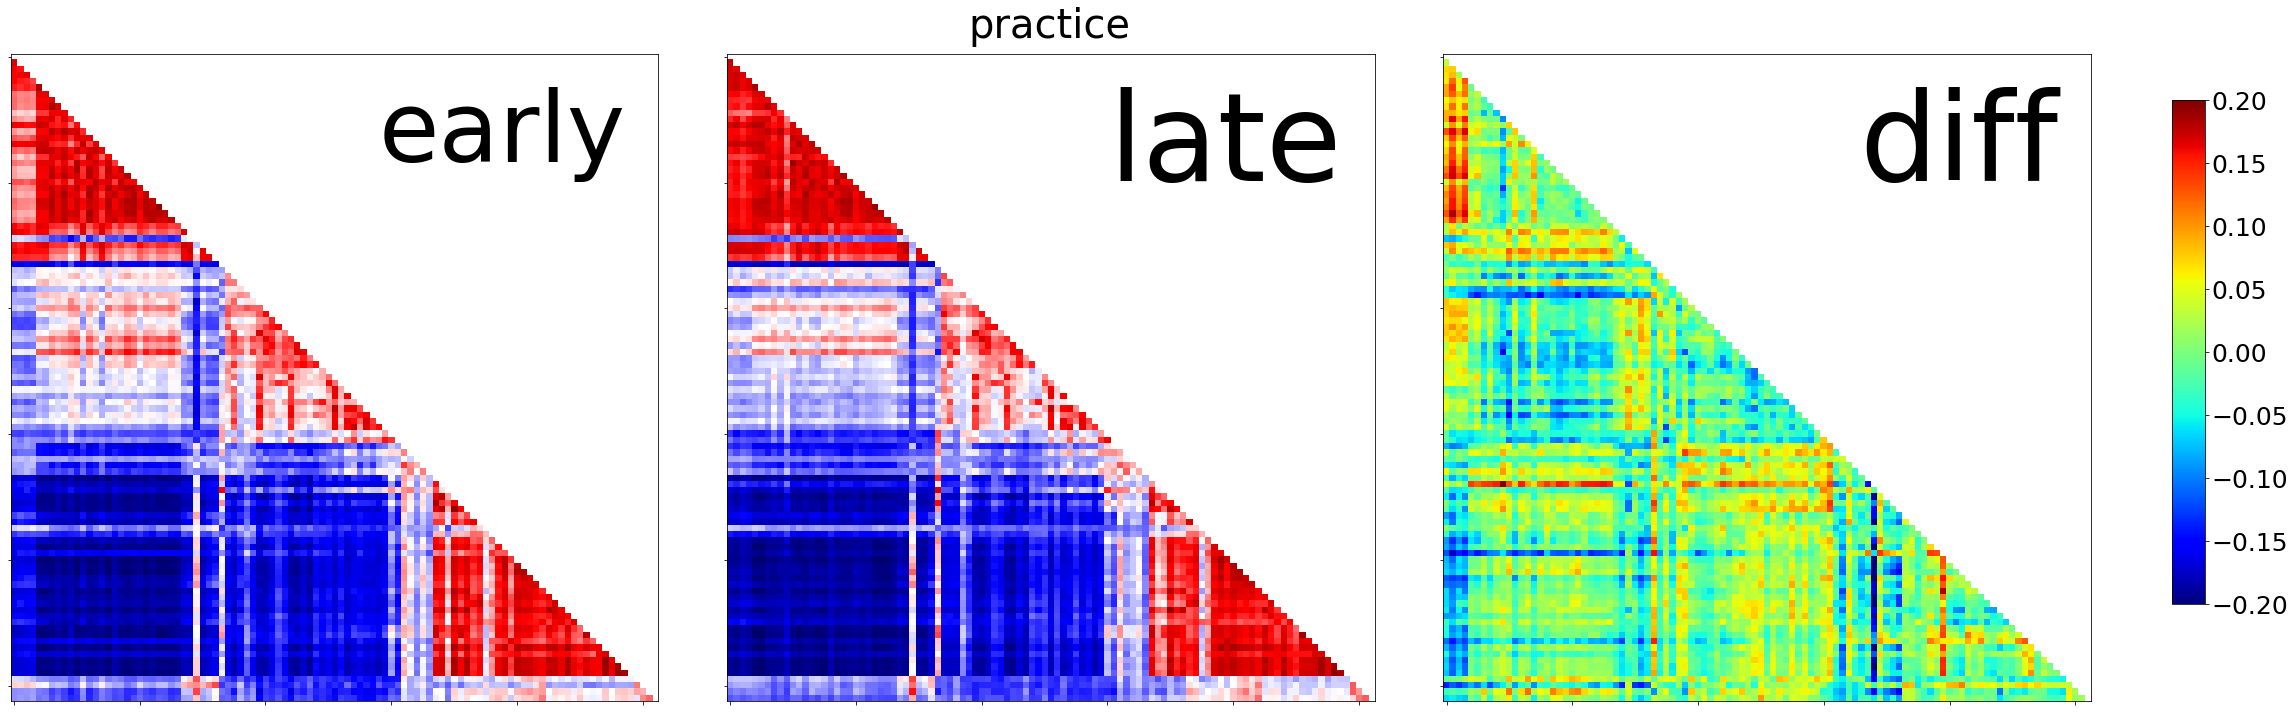

In [21]:
## practice
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*10, nrows*10))

for i, visit in enumerate(['early', 'late', 'diff']):
    ax = axs[i]
    if visit == 'diff':
        matrix = np.nanmean(allegiances[1,:,:3]-allegiances[0,:,:3], axis=(0,1))
        cmap='jet'
        vmax, vmin = .2, -.2
    else:
        ## GA or GB 30명, Run r01-r03 3개에 대한 평균
        matrix = np.nanmean(allegiances[i,:,:3], axis=(0,1))
        cmap='seismic'
        vmax, vmin = 1., 0.
    img = nplt.plot_matrix(
        matrix
        , vmax=vmax, vmin=vmin
        , tri='lower', title=visit
        , cmap=cmap, colorbar=False, axes=ax
    )
cax = fig.add_axes([1.02, .15, .015, .7])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=25)

fig.suptitle('practice', size=40)
fig.tight_layout()

/tmp/ipykernel_48588/955022808.py:14: RuntimeWarning: Mean of empty slice
  matrix = np.nanmean(allegiances[i,:,3:], axis=(0,1))
/tmp/ipykernel_48588/955022808.py:9: RuntimeWarning: Mean of empty slice
  matrix = np.nanmean(allegiances[1,:,3:]-allegiances[0,:,3:], axis=(0,1))
/tmp/ipykernel_48588/955022808.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


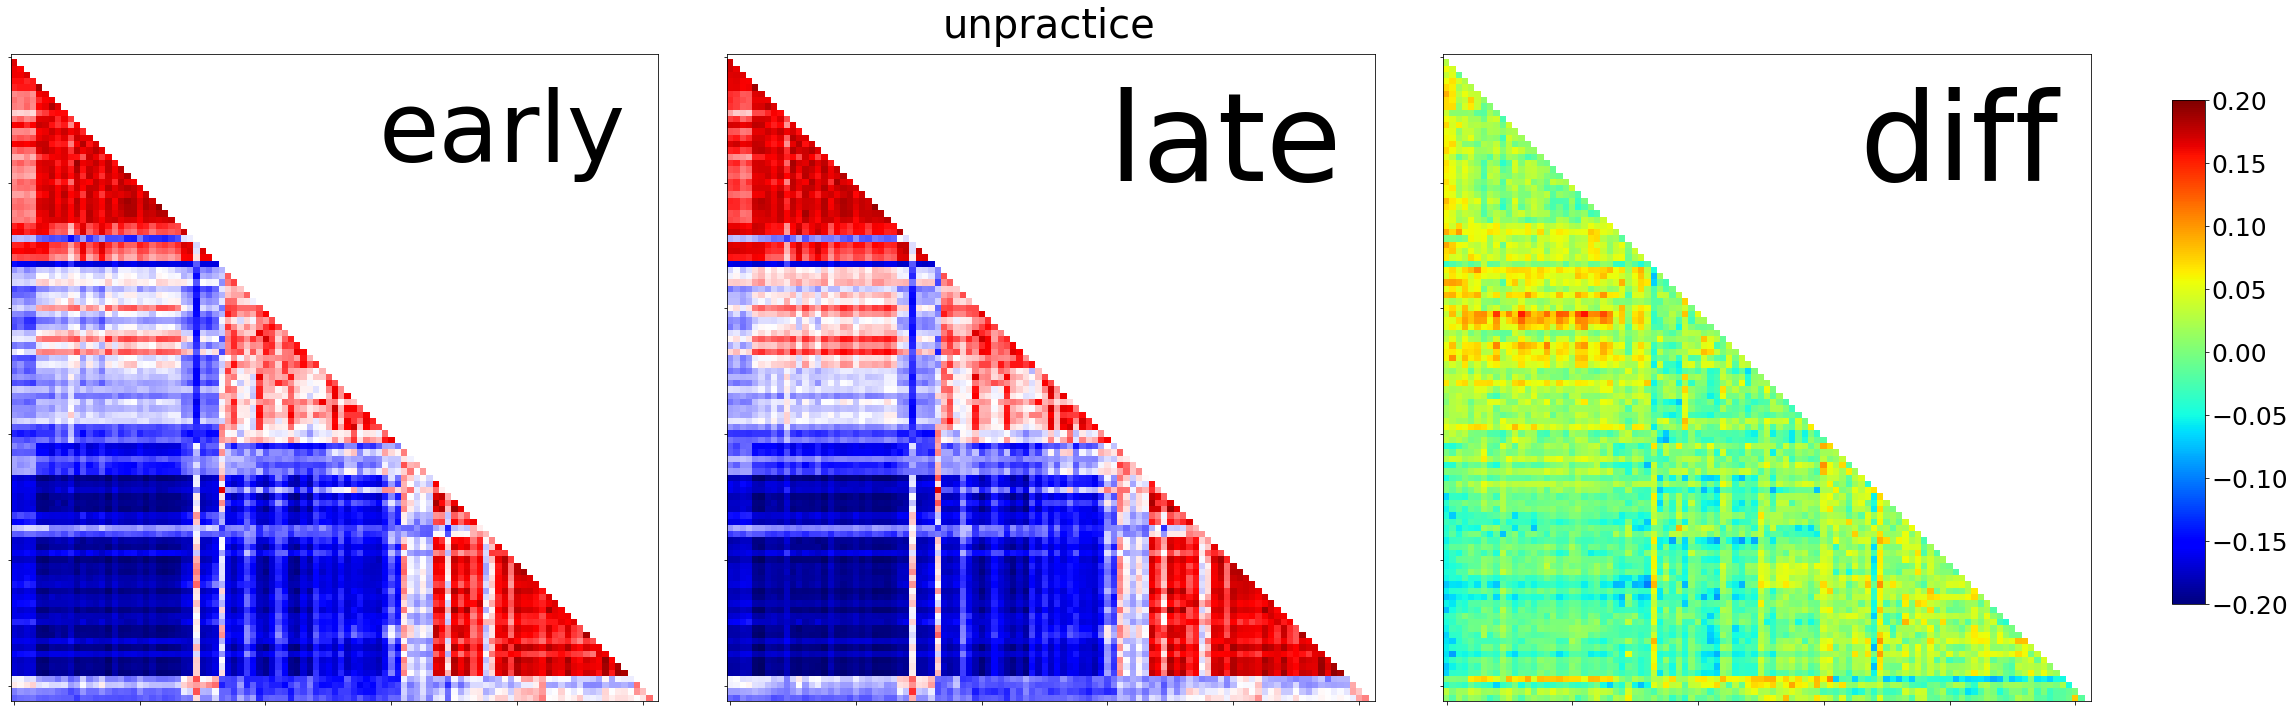

In [22]:
## unpractice
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*10, nrows*10))

for i, visit in enumerate(['early', 'late', 'diff']):
    ax = axs[i]
    if visit == 'diff':
        matrix = np.nanmean(allegiances[1,:,3:]-allegiances[0,:,3:], axis=(0,1))
        cmap='jet'
        vmax, vmin = .2, -.2
    else:
        ## GA or GB 30명, Run r04-r06 3개에 대한 평균
        matrix = np.nanmean(allegiances[i,:,3:], axis=(0,1))
        cmap='seismic'
        vmax, vmin = 1., 0.
    img = nplt.plot_matrix(
        matrix
        , vmax=vmax, vmin=vmin
        , tri='lower', title=visit
        , cmap=cmap, colorbar=False, axes=ax
    )
cax = fig.add_axes([1.02, .15, .015, .7])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=25)

fig.suptitle('unpractice', size=40)
fig.tight_layout()

### ⅲ) Integration and Recruitment

In [23]:
## Recruitment, 2 days, 30 subjects, 6 runs, 3 networks
R = np.ones((2,30,6,3)) * np.nan

networks = np.unique(staticcommunity)
for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for rr, run in enumerate(list_run):
            recruitment = calc_recruitment(allegiances[vv,ss,rr], staticcommunity)
            for nn, network in enumerate(networks):
                R[vv,ss,rr,nn] = np.mean(recruitment[staticcommunity==network])

/tmp/ipykernel_48588/2064154310.py:19: RuntimeWarning: Mean of empty slice
  recruitment[node] = np.nanmean(A[node, S==network])


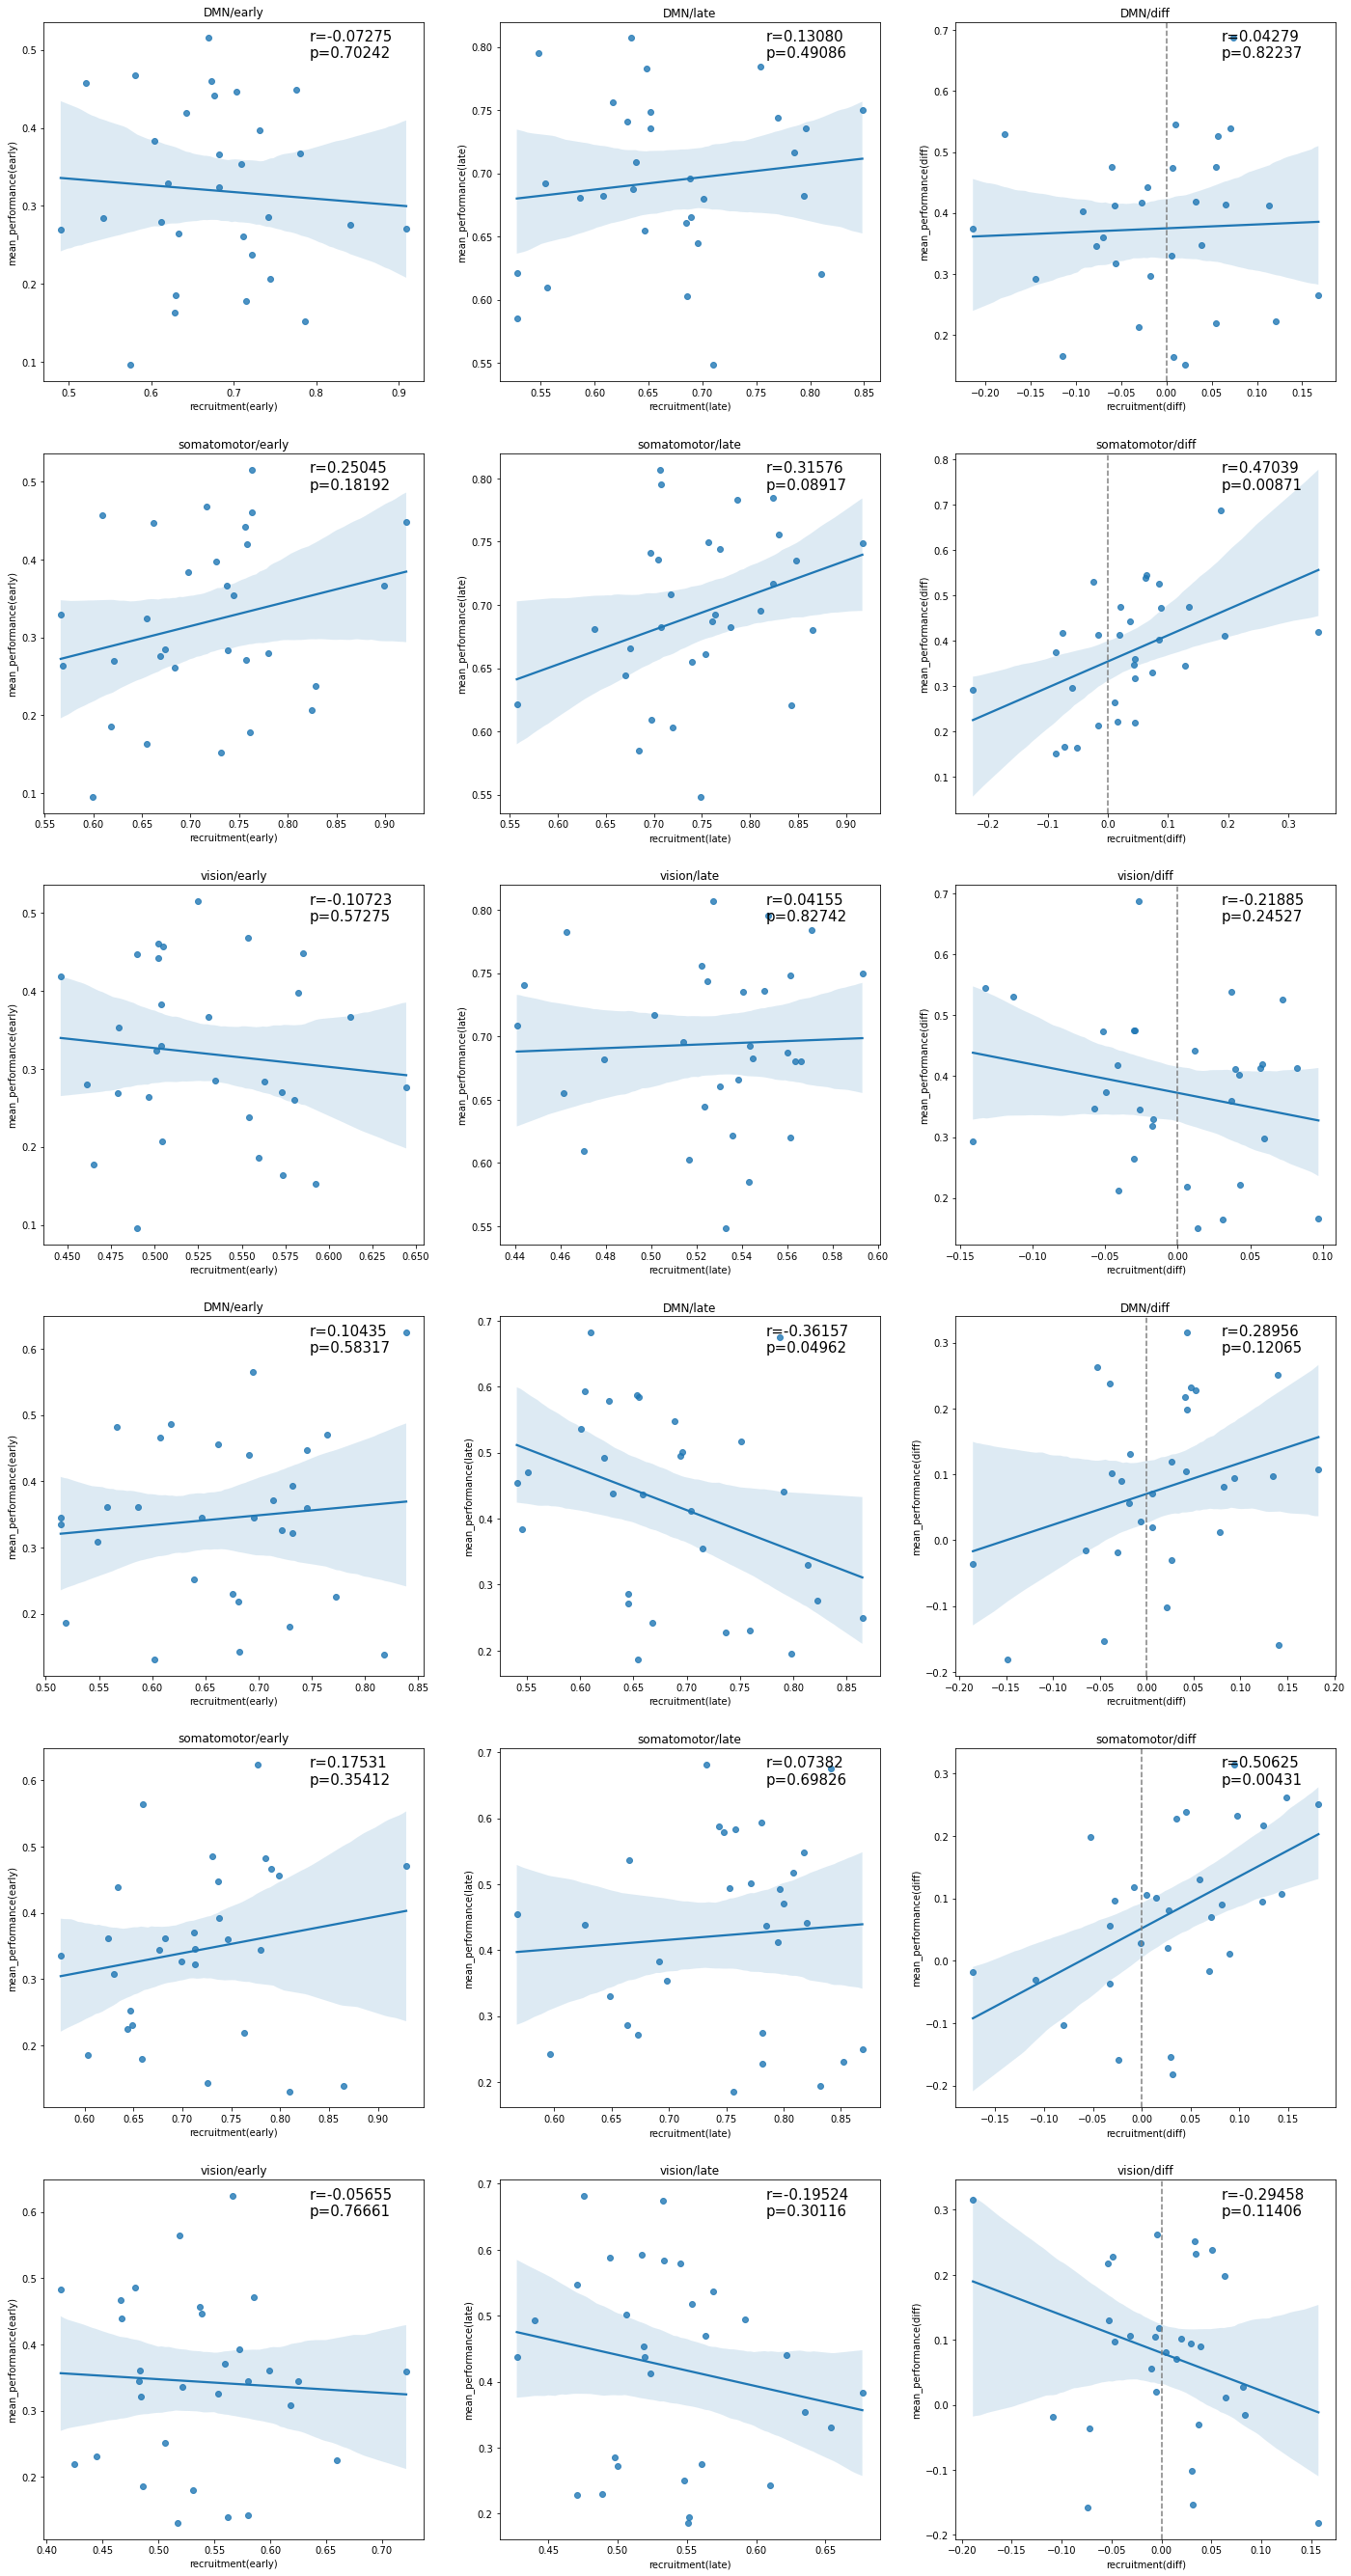

In [24]:
fig, axs = plt.subplots(nrows=3*2, ncols=3, figsize=(3*8, 3*2*8))

for mm, mapping in enumerate(['practice', 'unpractice']):
    mean_performance = np.nanmean(performance[:,:,3*mm:3*(mm+1)], axis=2)
    mean_R = np.nanmean(R[:,:,3*mm:3*(mm+1)], axis=2)
    for ii, network in enumerate(np.unique(staticcommunity)):
        row = 3*mm + ii
        idx = staticcommunity==network
        for col, visit in enumerate(['early', 'late', 'diff']):
            ax = axs[row,col]
            if visit == 'diff':
                x = mean_R[1,:,ii] - mean_R[0,:,ii]
                y = mean_performance[1,:] - mean_performance[0,:]
            else:
                x = mean_R[col,:,ii]
                y = mean_performance[col,:]

            X = x[~np.isnan(x)]
            Y = y[~np.isnan(x)]
            r, p = scipy.stats.pearsonr(X,Y)
            img = sns.regplot(
                x=X, y=Y, ax=ax
                , x_ci='ci'
            )
            img.set(
                title='%s/%s'%(network, visit)
                , xlabel='recruitment(%s)'%visit, ylabel='mean_performance(%s)'%visit
            )
            x0, x1 = img.get_xlim()
            y0, y1 = img.get_ylim()
            img.text(x0+(x1-x0)*.7, y0+(y1-y0)*.9, s='r=%.5f\np=%.5f'%(r,p), fontsize=15)
            if x0<=0 and x1>=0:
                ax.axvline(x=0, color='gray', linestyle='--')

In [25]:
## Integration, 2 days, 30 subjects, 6 runs, 3 networks
I = np.ones((2,30,6,3)) * np.nan

networks = np.unique(staticcommunity)
for vv, visit in enumerate(['early', 'late']):
    for ss, subj in enumerate(list_subj):
        for rr, run in enumerate(list_run):
            integration = calc_integration(allegiances[vv,ss,rr], staticcommunity)
            for nn, network in enumerate(networks):
                I[vv,ss,rr,nn] = np.mean(integration[staticcommunity==network])

/tmp/ipykernel_48588/1015756446.py:19: RuntimeWarning: Mean of empty slice
  integration[node] = np.nanmean(A[node, S!=network])


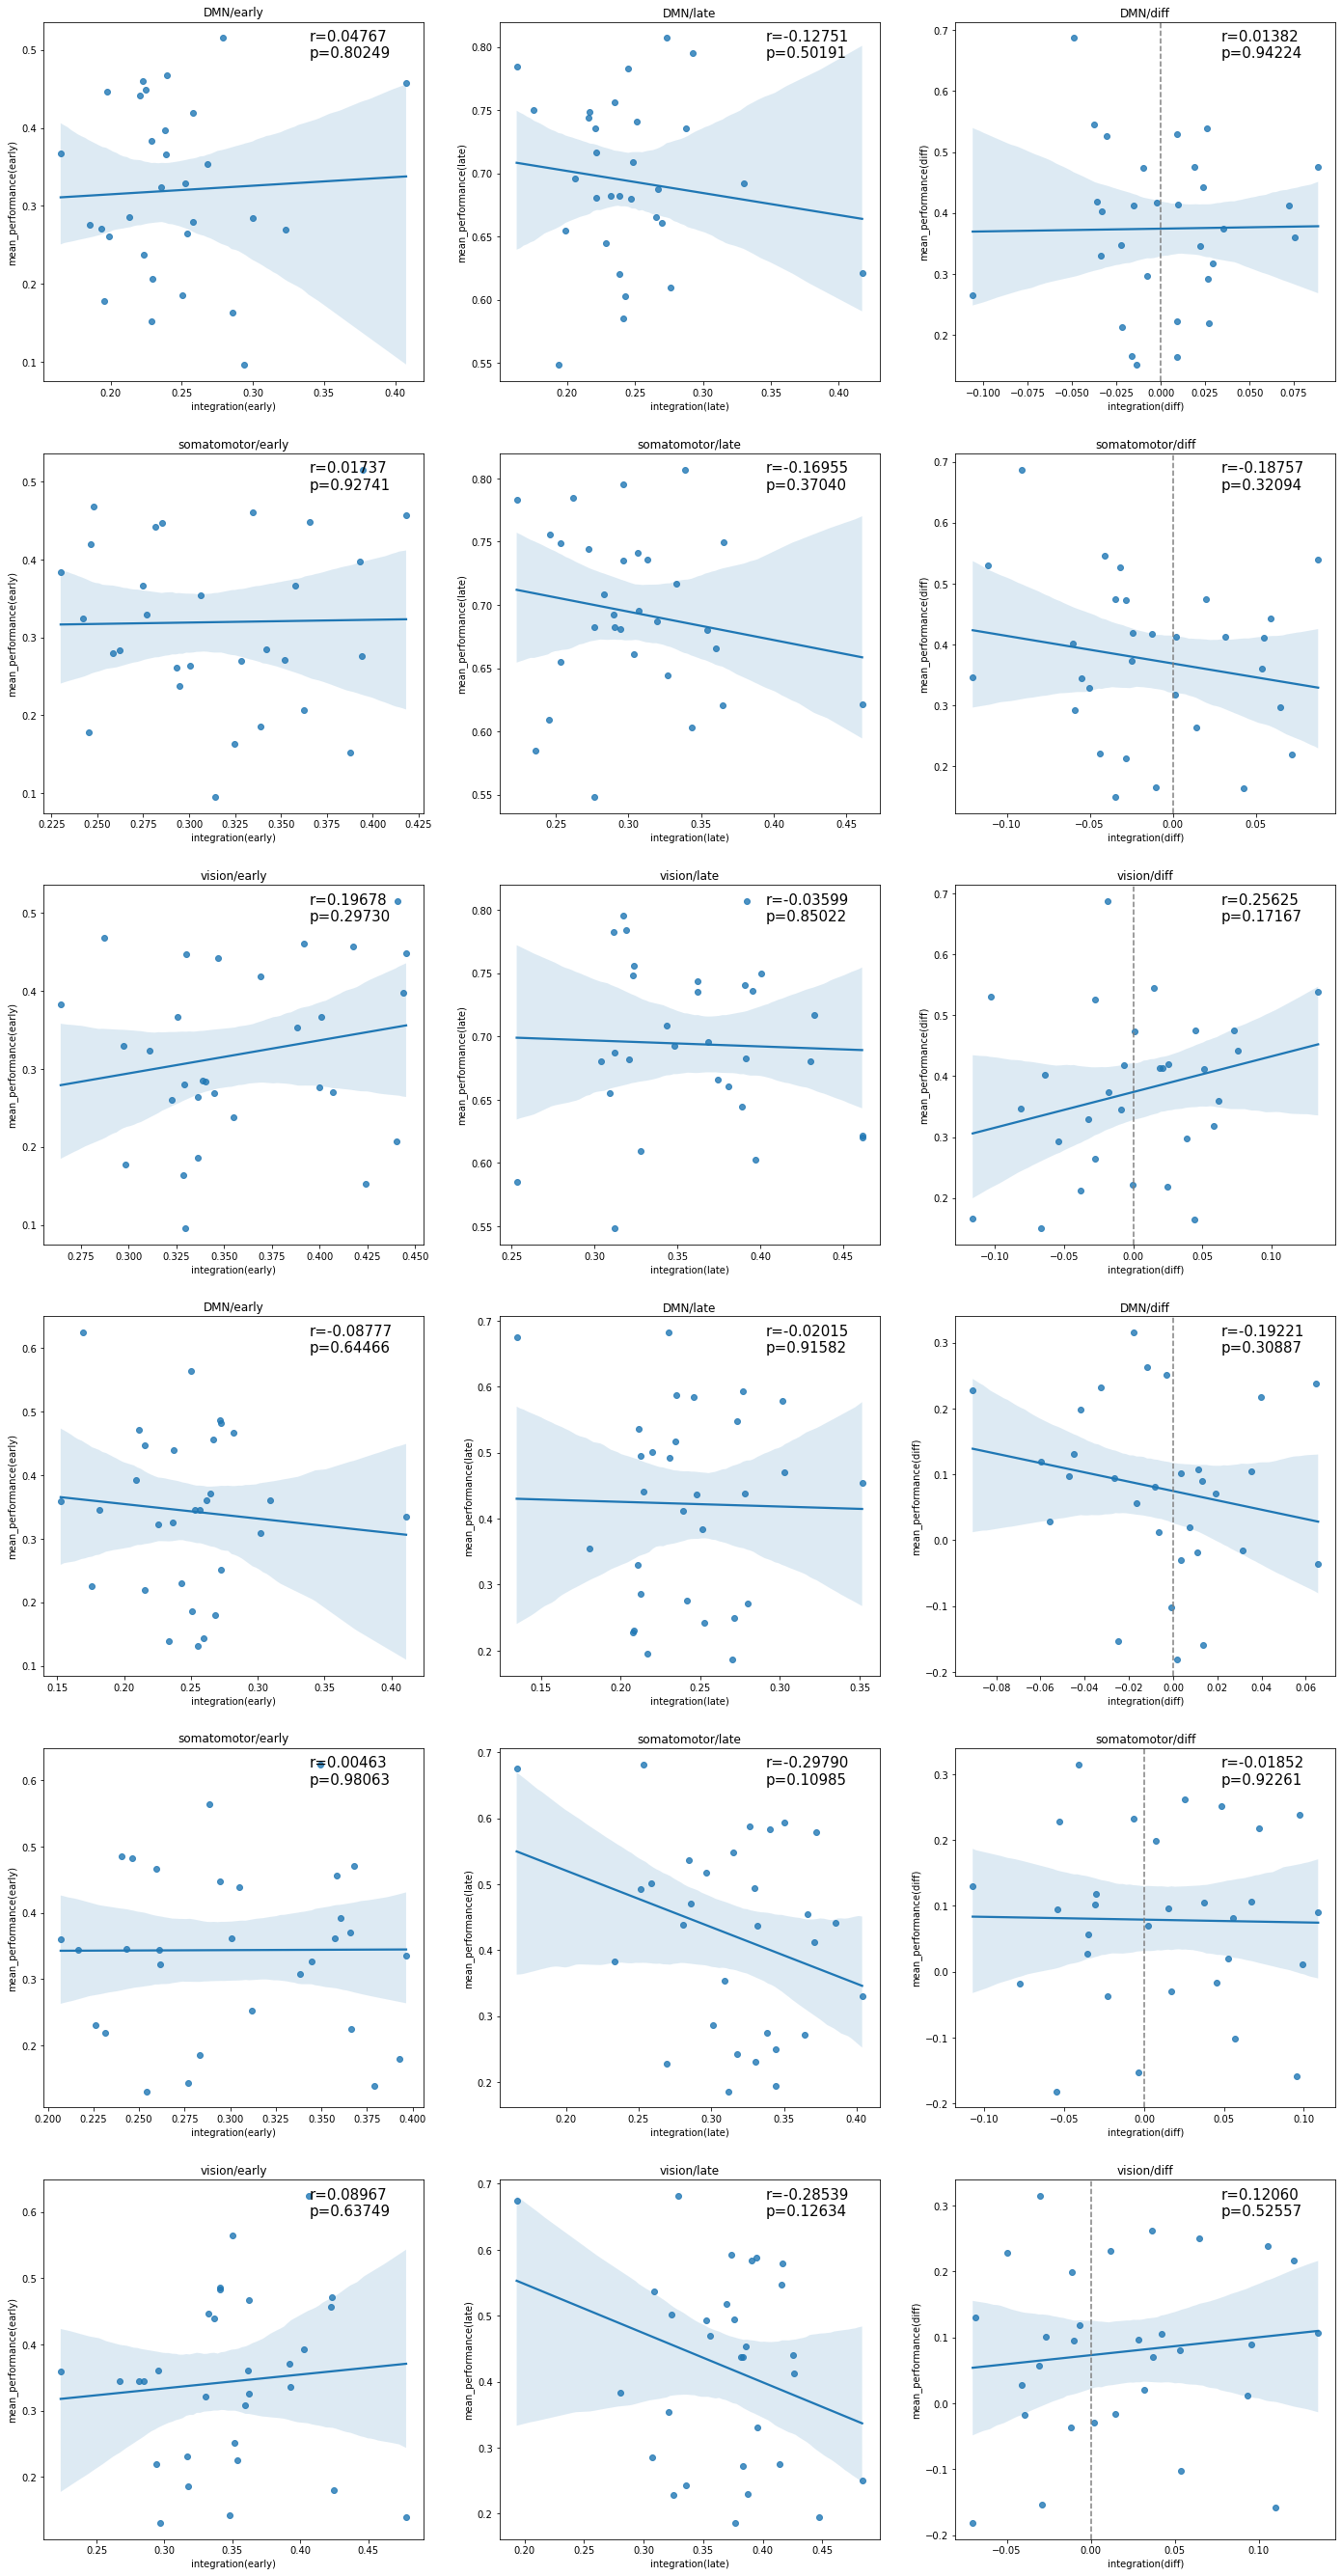

In [26]:
fig, axs = plt.subplots(nrows=3*2, ncols=3, figsize=(3*8, 3*2*8))

for mm, mapping in enumerate(['practice', 'unpractice']):
    mean_performance = np.nanmean(performance[:,:,3*mm:3*(mm+1)], axis=2)
    mean_I = np.nanmean(I[:,:,3*mm:3*(mm+1)], axis=2)
    for ii, network in enumerate(np.unique(staticcommunity)):
        row = 3*mm + ii
        idx = staticcommunity==network
        for col, visit in enumerate(['early', 'late', 'diff']):
            ax = axs[row,col]
            if visit == 'diff':
                x = mean_I[1,:,ii] - mean_I[0,:,ii]
                y = mean_performance[1,:] - mean_performance[0,:]
            else:
                x = mean_I[col,:,ii]
                y = mean_performance[col,:]

            X = x[~np.isnan(x)]
            Y = y[~np.isnan(x)]
            r, p = scipy.stats.pearsonr(X,Y)
            img = sns.regplot(
                x=X, y=Y, ax=ax
                , x_ci='ci'
            )
            img.set(
                title='%s/%s'%(network, visit)
                , xlabel='integration(%s)'%visit, ylabel='mean_performance(%s)'%visit
            )
            x0, x1 = img.get_xlim()
            y0, y1 = img.get_ylim()
            img.text(x0+(x1-x0)*.7, y0+(y1-y0)*.9, s='r=%.5f\np=%.5f'%(r,p), fontsize=15)
            if x0<=0 and x1>=0:
                ax.axvline(x=0, color='gray', linestyle='--')

---

In [51]:
recruitment = {}
integration = {}

for stage, MA in mean_MA_by_vvrr.items():
    nnodes = MA.shape[0]
    
    recruitment[stage] = np.zeros(nnodes)
    integration[stage] = np.zeros(nnodes)
    
    for node, system in enumerate(staticcommunity):
        recruitment[stage][node] = np.nanmean(MA[node,staticcommunity==system], axis=0)
        integration[stage][node] = np.nanmean(MA[node,staticcommunity!=system], axis=0)

In [30]:
df_r = pd.DataFrame.from_dict(recruitment, dtype=float)
sys_i = np.concatenate([staticcommunity for stage in df_r.columns])

df_r = pd.melt(df_r)
df_r['w/i network'] = sys_i
df_r['metric'] = 'recruitment'
df_r

variable     value  w/i network       metric
0    early_r01  0.650651  somatomotor  recruitment
1    early_r01  0.625911  somatomotor  recruitment
2    early_r01  0.608984  somatomotor  recruitment
3    early_r01  0.629948  somatomotor  recruitment
4    early_r01  0.713802  somatomotor  recruitment
..         ...       ...          ...          ...
613   late_r03  0.790357          DMN  recruitment
614   late_r03  0.391310          DMN  recruitment
615   late_r03  0.447500          DMN  recruitment
616   late_r03  0.530595          DMN  recruitment
617   late_r03  0.545238          DMN  recruitment

[618 rows x 4 columns]

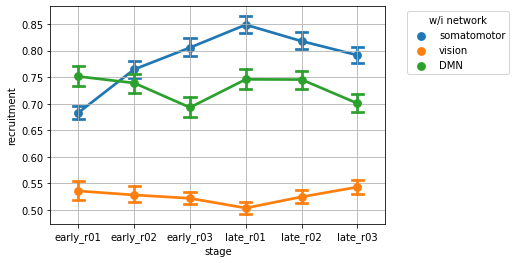

In [31]:
g = sns.pointplot(
    data=df_r, x='variable', y='value', hue='w/i network'
    , capsize=.2, ci=68
)
g.set(xlabel='stage', ylabel='recruitment')
g.grid(True)
g.legend(bbox_to_anchor=(1.05, 1.0), title='w/i network')

In [32]:
df_i = pd.DataFrame.from_dict(integration, dtype=float)
sys_i = np.concatenate([staticcommunity for stage in df_i.columns])

df_i = pd.melt(df_i)
df_i['w/o network'] = sys_i
df_i['metric'] = 'integration'
df_i

variable     value  w/o network       metric
0    early_r01  0.244167  somatomotor  integration
1    early_r01  0.249702  somatomotor  integration
2    early_r01  0.250417  somatomotor  integration
3    early_r01  0.248274  somatomotor  integration
4    early_r01  0.263690  somatomotor  integration
..         ...       ...          ...          ...
613   late_r03  0.136754          DMN  integration
614   late_r03  0.412500          DMN  integration
615   late_r03  0.367413          DMN  integration
616   late_r03  0.325311          DMN  integration
617   late_r03  0.311878          DMN  integration

[618 rows x 4 columns]

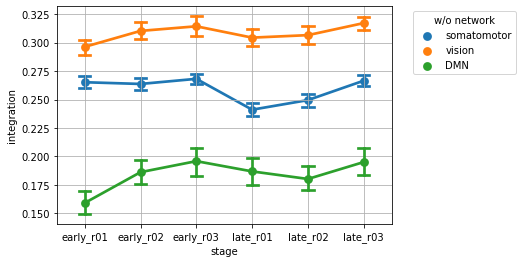

In [33]:
g = sns.pointplot(
    data=df_i, x='variable', y='value', hue='w/o network'
    , capsize=.2, ci=68
)
g.set(xlabel='stage', ylabel='integration')
g.grid(True)
g.legend(bbox_to_anchor=(1.05, 1.0), title='w/o network')

In [34]:
df = pd.concat([df_r, df_i])
df = df.reset_index(drop=True)
df

variable     value  w/i network       metric w/o network
0     early_r01  0.650651  somatomotor  recruitment         NaN
1     early_r01  0.625911  somatomotor  recruitment         NaN
2     early_r01  0.608984  somatomotor  recruitment         NaN
3     early_r01  0.629948  somatomotor  recruitment         NaN
4     early_r01  0.713802  somatomotor  recruitment         NaN
...         ...       ...          ...          ...         ...
1231   late_r03  0.136754          NaN  integration         DMN
1232   late_r03  0.412500          NaN  integration         DMN
1233   late_r03  0.367413          NaN  integration         DMN
1234   late_r03  0.325311          NaN  integration         DMN
1235   late_r03  0.311878          NaN  integration         DMN

[1236 rows x 5 columns]

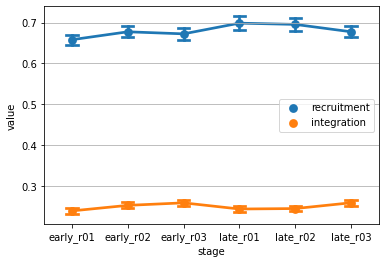

In [35]:
g = sns.pointplot(
    data=df, x='variable', y='value', hue='metric'
    , capsize=.2, ci=68
)
g.grid(True, which='major', axis='y')
g.set(xlabel='stage')
g.legend()

---